In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
from scipy.stats import lomax
import warnings
warnings.filterwarnings("ignore", message = 'DataFrame is highly fragmented.  This is usually the result of')

In [15]:
%run -i MABs_Classes_Functions
%run -i MABs_Exp_Generations
%run -i MABs_Comparisons
%run -i MABs_KL_Functions
%run -i MABs_Env_Generations

In [4]:
class player:
    def __init__(self, n_arms):
        self.regrets = []
        self.cumulative_regret = 0
        self.cumulative_regrets = []
        self.means = np.zeros(shape = n_arms)
        self.n_trials = np.zeros(shape = n_arms)
        self.choices = []
        self.observed_rewards = dict()
        for i in range(n_arms):
            self.observed_rewards[i] = []
        self.n_arms = n_arms
            
    def update_n_trials(self, choice):
        self.n_trials[choice] += 1
        
    def update_mean(self, choice, reward):
        self.observed_rewards[choice].append(reward**2)
        increment = (reward - self.means[choice])/self.n_trials[choice]
        self.means[choice] += increment
        
    def update_regret(self, reward, best_reward):
        regret = best_reward - reward
        self.regrets.append(regret)
        self.cumulative_regret += regret
        self.cumulative_regrets.append(self.cumulative_regret)

In [5]:
class env_generator:
    def __init__(self, n_arms, n_variables, dist = 'Dirichlet'):
        self.n_arms = n_arms
        self.n_variables = n_variables
        self.probs_matrix = None
        self.rewards = None
        self.best_arm = None
        self.all_means = None
        self.dist = dist
    
    def rewards_generator(self, random = False, lb = 0, ub = 0):
        if self.dist == 'Dirichlet':
            if not random:
                self.rewards = np.arange(1, self.n_variables + 1)
            else:
                self.rewards = np.random.uniform(lb, ub, size = self.n_arms)
        elif self.dist == 'Bernoulli':
            self.rewards = np.array([0,1])
    
    def probs_generator(self, conc):
        self.probs_matrix = np.zeros(shape = (self.n_arms, self.n_variables))
        
        if self.dist == 'Dirichlet':
            alpha = [conc for i in range(self.n_arms)]
            p_generator = np.random.default_rng()
            for j in range(self.n_arms):
                self.probs_matrix[j, :] = p_generator.dirichlet(alpha = alpha)
                
        elif self.dist == 'Bernoulli':
            for j in range(self.n_arms):
                p = np.random.uniform(0,1)
                self.probs_matrix[j, :] = [1-p, p]
    
    def best_arm_def(self):
        if self.dist == 'Dirichlet':
            self.all_means = (self.rewards*self.probs_matrix).sum(axis = 1)
        elif self.dist == 'Bernoulli':
            self.all_means = self.probs_matrix[:, 1]
        self.best_arm = np.argmax(self.all_means)

In [6]:
def env_generation(n_arms, n_variables, conc = None, dist = 'Dirichlet', random = False, lb = 0, ub = 0):
    env = env_generator(n_arms = n_arms, n_variables = n_variables, dist = dist)
    env.rewards_generator(random = random, lb = lb, ub = ub)
    env.probs_generator(conc = conc)
    env.best_arm_def()
    return env

In [7]:
def cum_regret_plot(x, y, labels, big = False, title = None):
    if big:
        plt.figure(figsize = (10,7))
    for i in range(len(x)):
        plt.plot(x[i], y[i], label = labels[i])
    plt.axhline(0, color = 'black')
    plt.grid()
    plt.legend()
    if title is None:
        plt.title('Cumulative Regret')
    else:
        plt.title(title)
    plt.show()

# Distributions Analysis

## Poisson

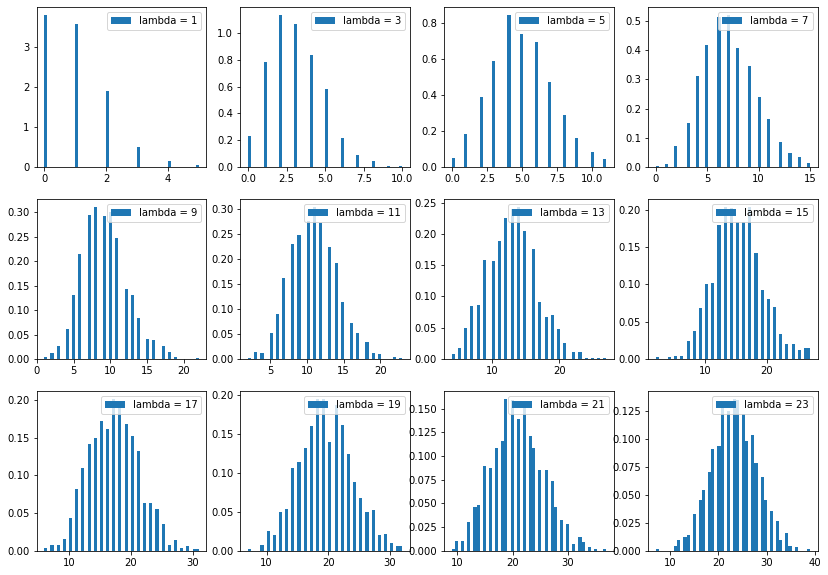

In [72]:
lambdas = np.arange(1, 25, 2)
plt.figure(figsize = (14, 10))
i = 1
for l in lambdas:
    plt.subplot(3,4,i)
    sample = np.random.poisson(lam = l, size = 1000)
    plt.hist(sample, bins = 50, density = True, label = f'lambda = {l}')
    plt.legend()
    i += 1
plt.show()

## Exponential

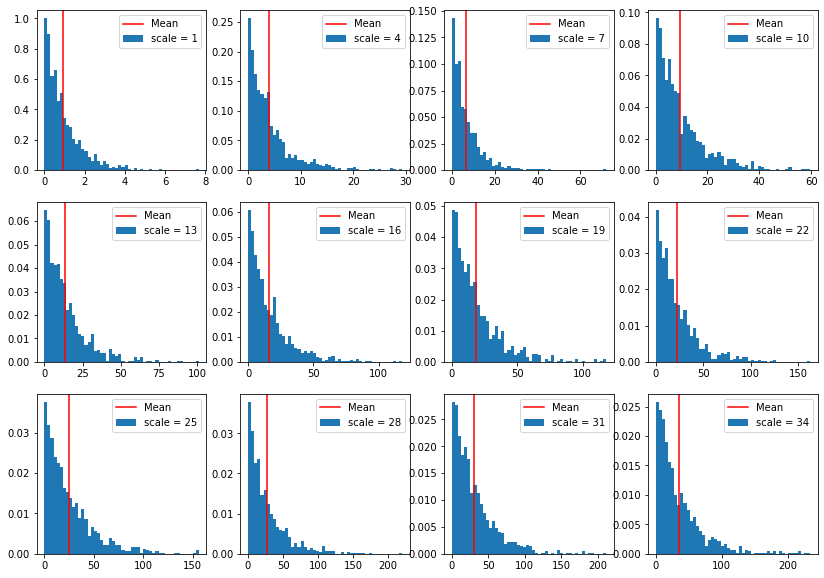

In [39]:
lambdas = np.arange(1, 37, 3)
plt.figure(figsize = (14, 10))
i = 1
for l in lambdas:
    plt.subplot(3,4,i)
    sample = np.random.exponential(scale = l, size = 1000)
    plt.hist(sample, bins = 50, density = True, label = f'scale = {l}')
    plt.axvline(np.mean(sample), color = 'red', label = 'Mean')
    plt.legend()
    i += 1
plt.show()

# UCB1

In [7]:
class ucb_1_player(player):
    def __init__(self, n_arms, beta):
        super().__init__(n_arms)
        self.ucbs = np.zeros(shape = n_arms)
        self.beta = beta
        
    def compute_ucbs(self, current_round):
        self.ucbs[self.n_trials > 0] = np.sqrt(2*(self.beta**2)*np.log(current_round)/self.n_trials[self.n_trials > 0])
        
    def choice(self):
        choice = np.argmax(self.means + self.ucbs)
        self.choices.append(choice)
        return choice

In [8]:
def ucb_1_experiment_generation(n_rounds, n_iterations, beta, env = None, dist = 'Dirichlet', lambdas = None, conc = None):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Dirichlet':
            env = env_generation(n_arms = 10, n_variables = 10, conc = conc)
            ranked_means = sorted(env.all_means)
            player_1 = ucb_1_player(n_arms = env.n_arms, beta = beta)
            
        elif dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = ucb_1_player(n_arms = env.n_arms, beta = beta)
            
        else:
            player_1 = ucb_1_player(n_arms = len(lambdas), beta = beta)
            
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
            else:
                player_1.compute_ucbs(i)
                choice = player_1.choice()
            
            if dist == 'Dirichlet' or dist == 'Bernoulli':
                choices_rank.append(ranked_means.index(env.all_means[choice]))
            
            if dist == 'Dirichlet' or dist == 'Bernoulli': 
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
            elif dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            player_1.update_regret(reward, best_reward)
        all_regrets[j, :] = player_1.cumulative_regrets
                                    
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
    return all_regrets, all_choices

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.44s/it]


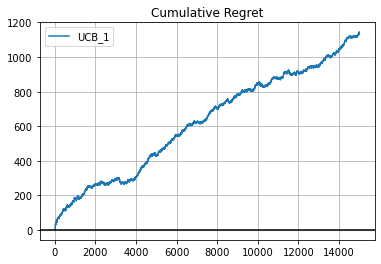

In [91]:
n_rounds = 15000
n_iterations = 10
all_regrets = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = 1, conc = 0.5)[0]
cum_regret_plot([np.arange(1, n_rounds + 1)], [all_regrets.mean(axis = 0)], labels = ['UCB_1'])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:58<00:00,  2.93s/it]


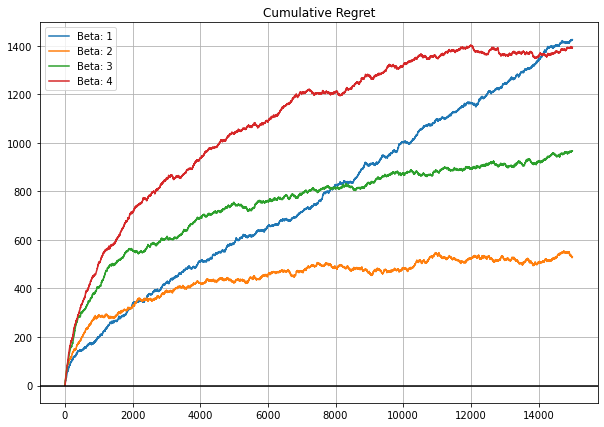

All Means: [0.81518663 0.2627467  0.51181025 0.2118394  0.42471833 0.58213649
 0.92244456 0.89527081 0.41931762 0.25703401]


In [833]:
n_rounds = 15000
n_iterations = 20
betas = [1,2,3,4]
labels = [f'Beta: {i}' for i in betas]
x = []
y = []

for i in range(len(betas)):
    all_regrets = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = betas[i], conc = 0.5)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.91s/it]


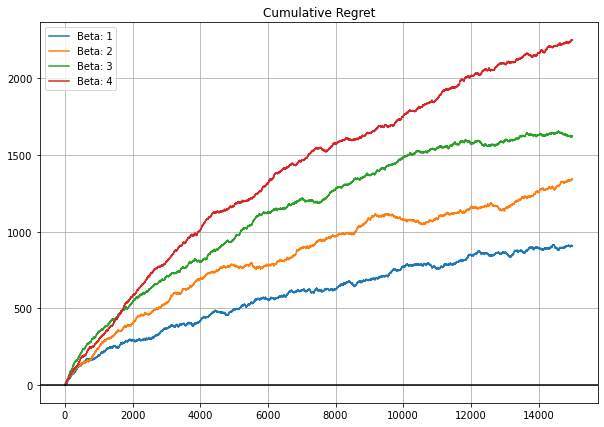

All Means: [0.81518663 0.2627467  0.51181025 0.2118394  0.42471833 0.58213649
 0.92244456 0.89527081 0.41931762 0.25703401]


In [829]:
n_rounds = 15000
n_iterations = 15
betas = [1,2,3,4]
labels = [f'Beta: {i}' for i in betas]
x = []
y = []
for beta in betas:
    all_regrets = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta, conc = 10)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [00:41<00:00,  2.74s/it]


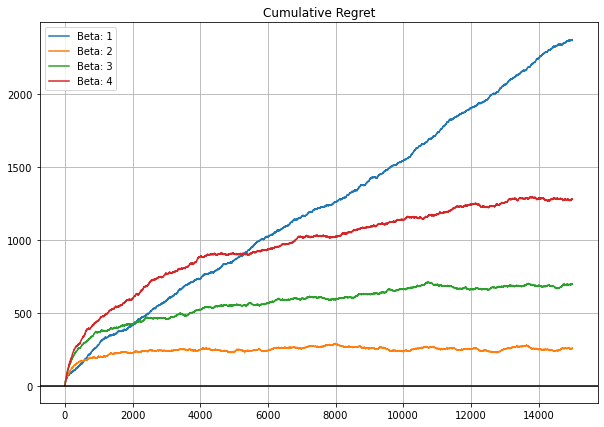

In [103]:
n_rounds = 15000
n_iterations = 15
betas = [1,2,3,4]
labels = [f'Beta: {i}' for i in betas]
x = []
y = []

for i in range(len(betas)):
    all_regrets = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = betas[i], conc = 0.1)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:39<00:00,  3.91s/it]


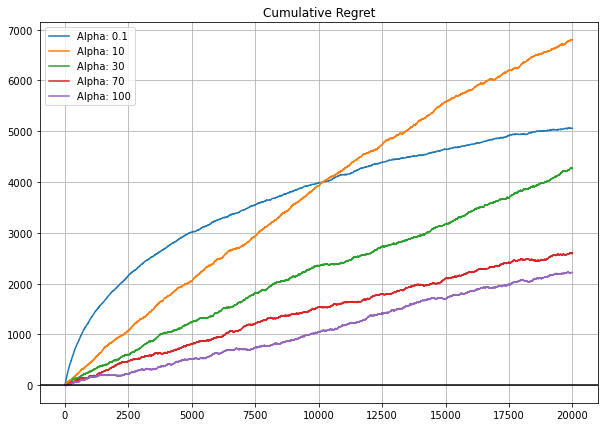

In [831]:
n_rounds = 20000
n_iterations = 10
concs = [0.1, 10, 30, 70, 100]
labels = [f'Alpha: {i}' for i in concs]
x = []
y = []

for conc in concs:
    all_regrets = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = 10, conc = conc)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Bernoulli

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.94s/it]


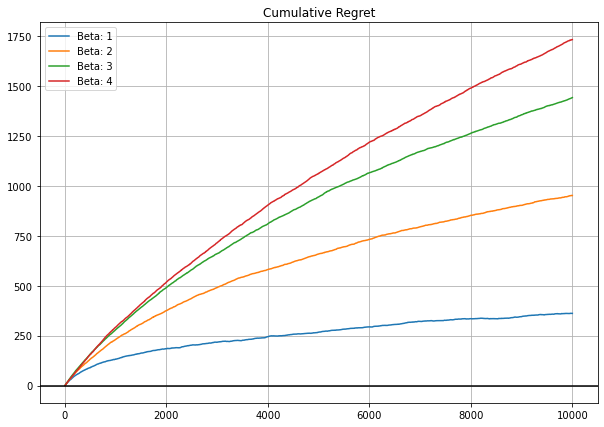

In [832]:
n_rounds = 10000
n_iterations = 10
dist = 'Bernoulli'
betas = [1,2,3,4]
labels = [f'Beta: {i}' for i in betas]
x = []
y = []

for i in range(len(betas)):
    all_regrets = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = betas[i], dist = dist)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
cum_regret_plot(x, y, labels, big = True)

## Poisson

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.38it/s]


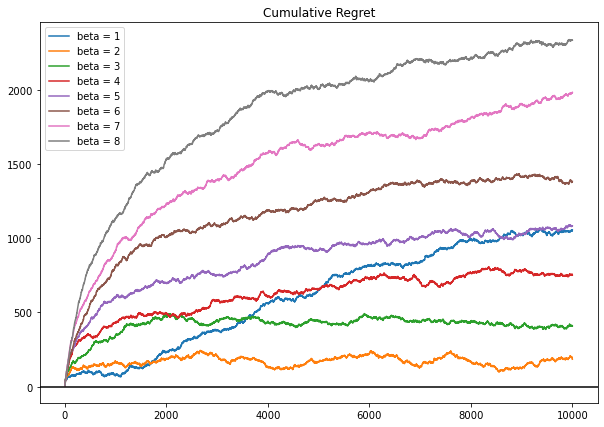

In [181]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(1,11,1)
betas = [1,2,3,4,5,6,7,8]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_1_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.30it/s]


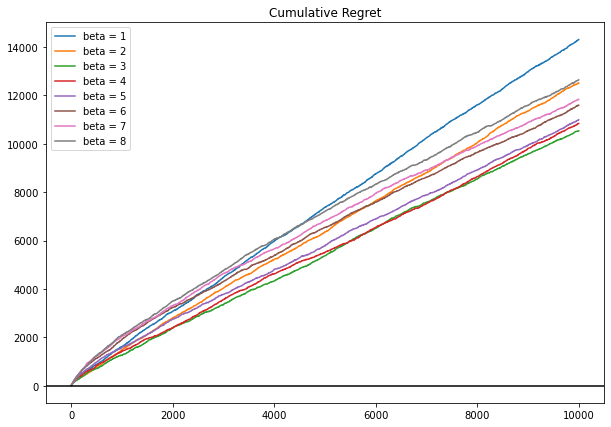

In [130]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(10,21,1)
betas = [1,2,3,4,5,6,7,8]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_1_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

## Exponential

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.43it/s]


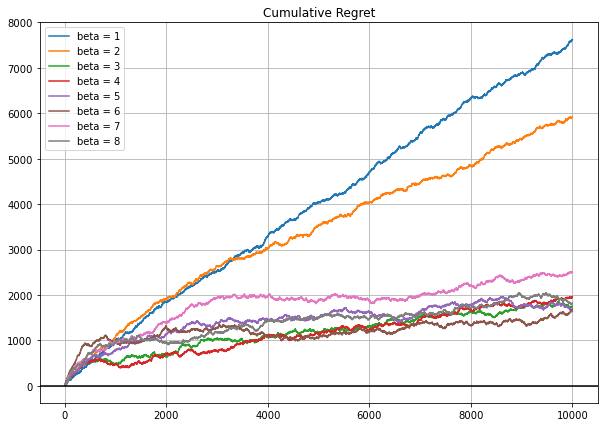

In [769]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(1,11,1)
betas = [1,2,3,4,5,6,7,8]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_1_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.02it/s]


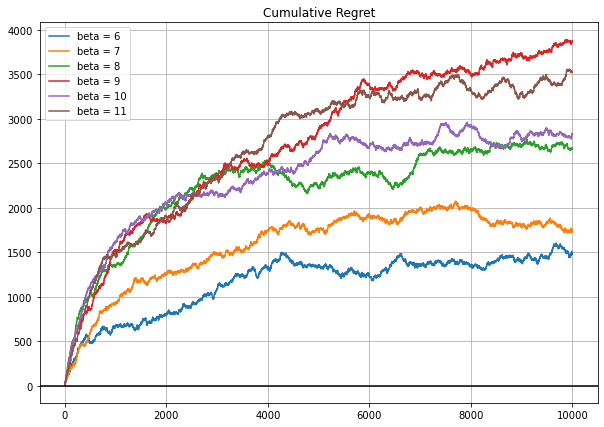

In [771]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(1,11,1)
betas = [6,7,8,9,10,11]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_1_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.41it/s]


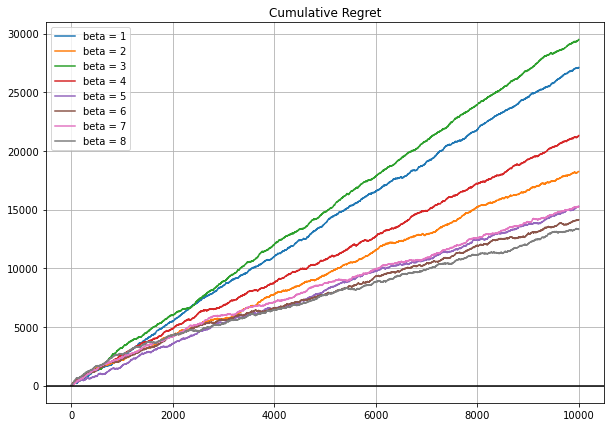

In [770]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(10,21,1)
betas = [1,2,3,4,5,6,7,8]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_1_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.21it/s]


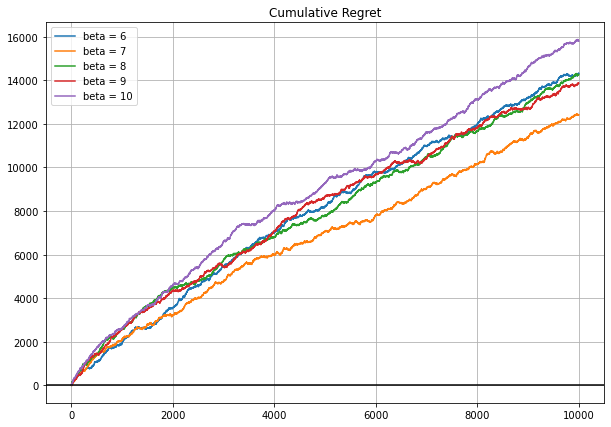

In [772]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(10,21,1)
betas = [6,7,8,9,10]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_1_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

# UCB - V

In [9]:
class ucb_v_player(player):
    def __init__(self, n_arms, beta):
        super().__init__(n_arms)
        self.beta = beta
        self.ucbs = np.zeros(shape = n_arms)
        self.variances = np.zeros(shape = n_arms)
        self.means_squared = np.zeros(shape = n_arms)
    
    def compute_ucbs(self, current_round):
        ucb_1 = np.sqrt((2*np.log(current_round)*self.variances[self.n_trials > 0])/self.n_trials[self.n_trials > 0])
        ucb_2 = 3*np.log(current_round)*self.beta/self.n_trials[self.n_trials > 0]
        self.ucbs[self.n_trials > 0] = ucb_1 + ucb_2
        
    def choice(self):
        choice = np.argmax(self.means + self.ucbs)
        self.choices.append(choice)
        return choice
    
    def update_mean(self, choice, reward):
        increment = (reward - self.means[choice])/self.n_trials[choice]
        self.means[choice] += increment
        increment_squared = (reward**2 - self.means_squared[choice])/self.n_trials[choice]
        self.means_squared[choice] += increment_squared
    
    def update_variance(self, choice):
        self.variances[choice] = self.means_squared[choice] - self.means[choice]**2

In [10]:
def ucb_v_experiment_generation(n_rounds, n_iterations, beta, env = None, dist = 'Dirichlet', lambdas = None, conc = None):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Dirichlet':
            env = env_generation(n_arms = 10, n_variables = 10, conc = conc)
            ranked_means = sorted(env.all_means)
            player_1 = ucb_v_player(n_arms = env.n_arms, beta = beta)
        elif dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = ucb_v_player(n_arms = env.n_arms, beta = beta)
            
        else:
            player_1 = ucb_v_player(n_arms = len(lambdas), beta = beta)
            
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
            else:
                player_1.compute_ucbs(i)
                choice = player_1.choice()
            
            if dist == 'Dirichlet' or dist == 'Bernoulli':
                choices_rank.append(ranked_means.index(env.all_means[choice]))

            if dist == 'Dirichlet' or dist == 'Bernoulli': 
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
            elif dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            player_1.update_variance(choice)
            player_1.update_regret(reward, best_reward)
            
        all_regrets[j, :] = player_1.cumulative_regrets
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
    return all_regrets, all_choices

## Dirichlet

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.61s/it]


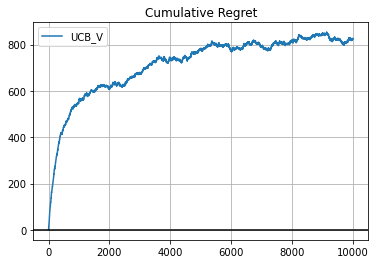

In [843]:
n_rounds = 10000
n_iterations = 10
all_regrets = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = 1, conc = 0.5)[0]
cum_regret_plot([np.arange(1, n_rounds + 1)], [all_regrets.mean(axis = 0)], labels = ['UCB_V'])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.57s/it]


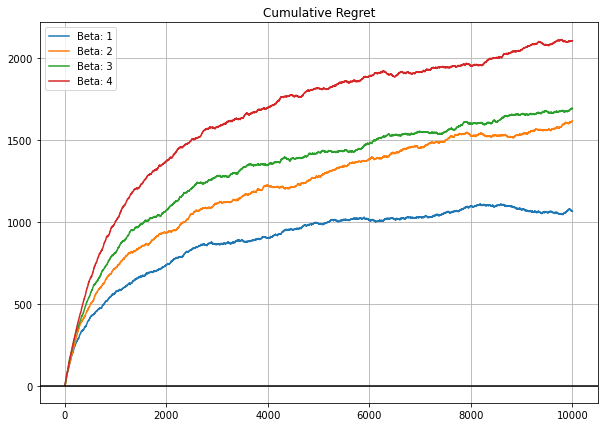

In [844]:
n_rounds = 10000
n_iterations = 20
betas = np.arange(1,5,1)
labels = [f'Beta: {i}' for i in betas]
x = []
y = []

for i in range(len(betas)):
    all_regrets = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = betas[i], conc = 0.5)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:51<00:00,  2.59s/it]


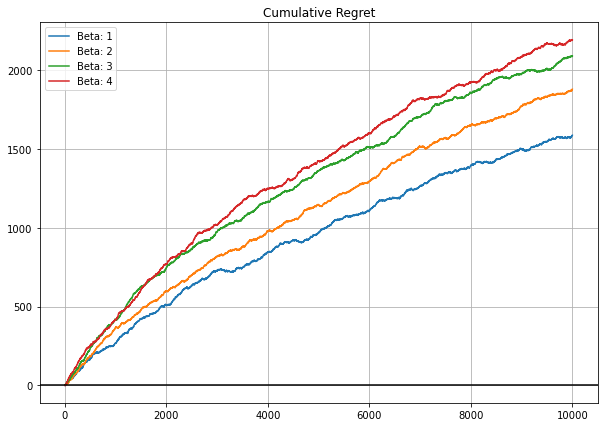

In [845]:
n_rounds = 10000
n_iterations = 20
betas = np.arange(1,5,1)
labels = [f'Beta: {i}' for i in betas]
x = []
y = []
for beta in betas:
    all_regrets = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta, conc = 10)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:46<00:00,  2.34s/it]


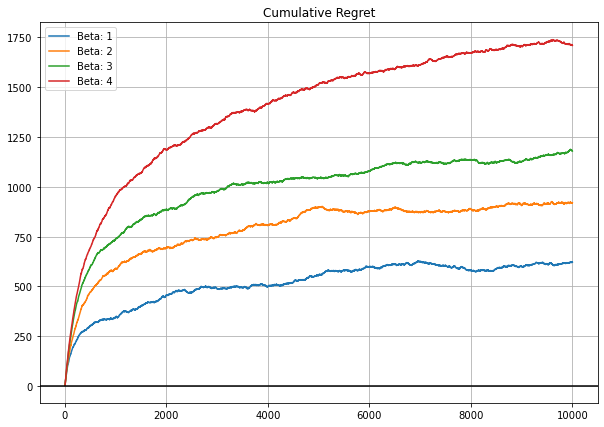

All Means: [0.81518663 0.2627467  0.51181025 0.2118394  0.42471833 0.58213649
 0.92244456 0.89527081 0.41931762 0.25703401]


In [846]:
n_rounds = 10000
n_iterations = 20
betas = np.arange(1, 5, 1)
labels = [f'Beta: {i}' for i in betas]
x = []
y = []
for beta in betas:
    all_regrets = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta, conc = 0.1)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
cum_regret_plot(x, y, labels, big = True)

print(f'All Means: {env.all_means}')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:24<00:00,  2.41s/it]


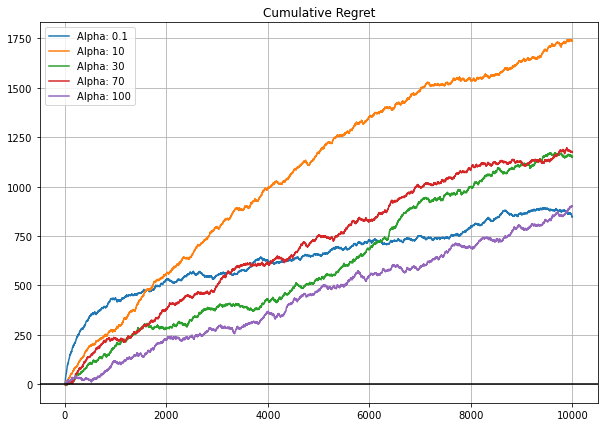

In [847]:
n_rounds = 10000
n_iterations = 10
concs = [0.1, 10, 30, 70, 100]
labels = [f'Alpha: {i}' for i in concs]
x = []
y = []

for conc in concs:
    all_regrets = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = 1, conc = conc)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Bernoulli

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]


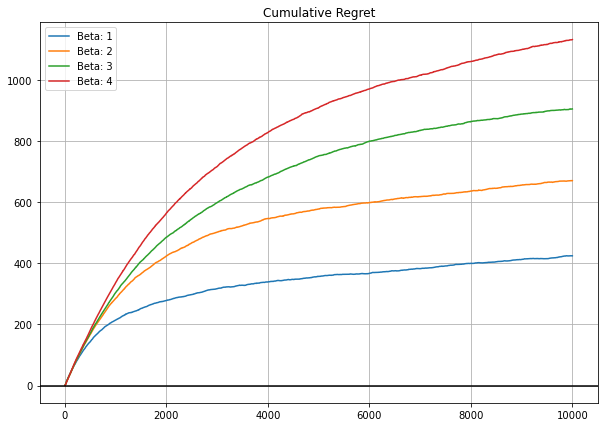

In [848]:
n_rounds = 10000
n_iterations = 20
dist = 'Bernoulli'
betas = [1,2,3,4]
labels = [f'Beta: {i}' for i in betas]
x = []
y = []

for i in range(len(betas)):
    all_regrets = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = betas[i], dist = dist)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
cum_regret_plot(x, y, labels, big = True)

## Poisson

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:00<00:00,  6.07s/it]


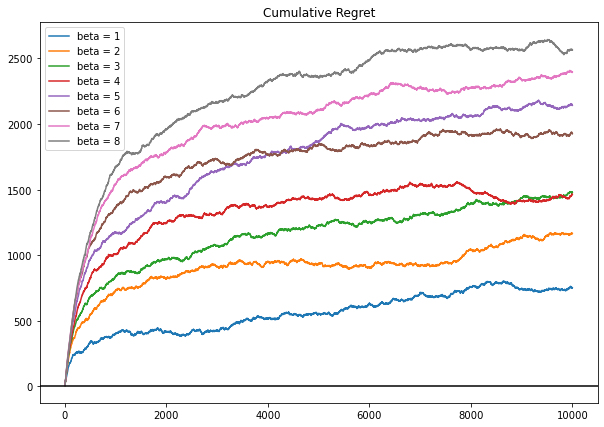

In [197]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(1,11,1)
betas = [1,2,3,4,5,6,7,8]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_v_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:59<00:00,  5.90s/it]


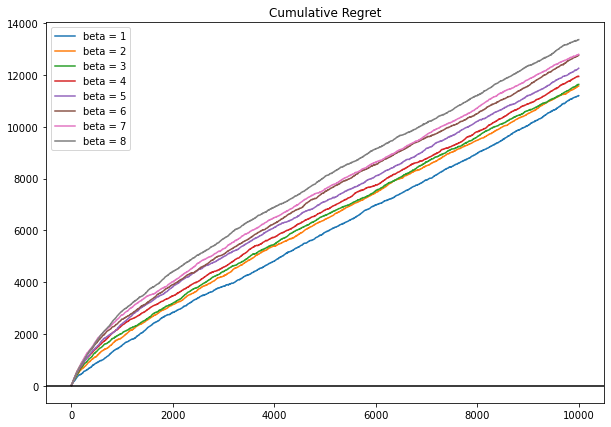

In [199]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(10,21,1)
betas = [1,2,3,4,5,6,7,8]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_v_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

## Exponential

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:12<00:00,  1.25s/it]


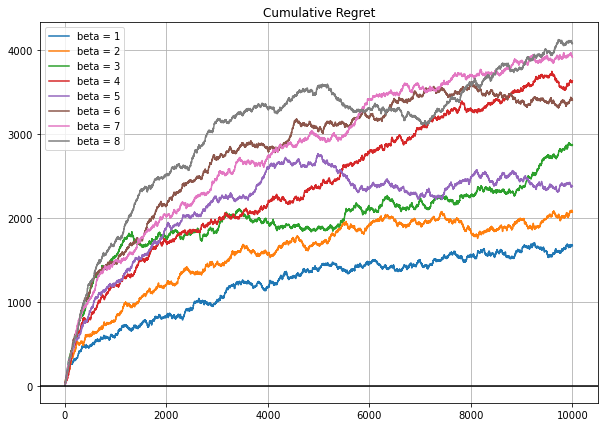

In [767]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(1,11,1)
betas = [1,2,3,4,5,6,7,8]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_v_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:20<00:00,  1.03s/it]


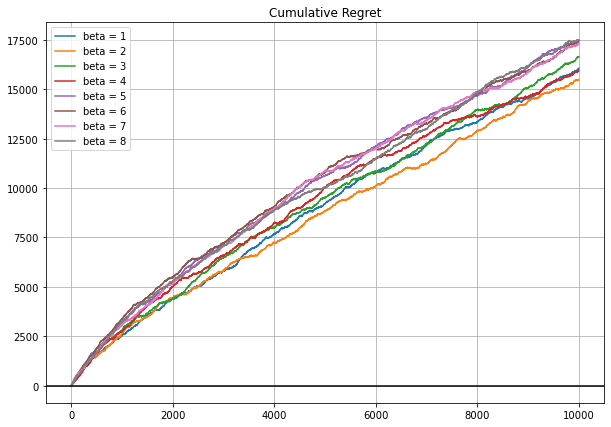

In [773]:
n_arms = 10
n_rounds = 10000
n_iterations = 20
dist = 'Exponential'
lambdas = np.arange(10,21,1)
betas = [1,2,3,4,5,6,7,8]
y = []
labels = []
for beta in betas:
    all_regrets = ucb_v_experiment_generation(beta = beta, n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
    y.append(all_regrets.mean(axis = 0))
    labels.append(f'beta = {beta}')
cum_regret_plot([np.arange(1, 1 + n_rounds) for i in range(len(betas))], y, labels, big = True)

# UCB MOSS

In [11]:
class ucb_moss_player(player):
    def __init__(self, n_arms, n_rounds):
        super().__init__(n_arms)
        self.ucbs = np.zeros(shape = n_arms)
        self.n_rounds = n_rounds
        self.n_arms = n_arms
        
    def compute_ucbs(self, current_round):
        log_arg = self.n_rounds/self.n_arms*self.n_trials[self.n_trials > 0]
        log_arg[log_arg < 1] = 1
        self.ucbs[self.n_trials > 0] = np.sqrt((4/self.n_trials[self.n_trials > 0])*np.log(log_arg))
        
    def choice(self):
        choice = np.argmax(self.means + self.ucbs)
        self.choices.append(choice)
        return choice

In [12]:
def ucb_moss_experiment_generation(n_rounds, n_iterations, env = None, dist = 'Dirichlet', lambdas = None, conc = None):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Dirichlet':
            env = env_generation(n_arms = 10, n_variables = 10, conc = conc)
            ranked_means = sorted(env.all_means)
            player_1 = ucb_moss_player(n_arms = env.n_arms, n_rounds = n_rounds)
        elif dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = ucb_moss_player(n_arms = env.n_arms, n_rounds = n_rounds)
        else:
            player_1 = ucb_moss_player(n_arms = len(lambdas), n_rounds = n_rounds)
            
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
            else:
                player_1.compute_ucbs(i)
                choice = player_1.choice()
                
            if dist == 'Dirichlet' or dist == 'Bernoulli':
                choices_rank.append(ranked_means.index(env.all_means[choice]))

            if dist == 'Dirichlet' or dist == 'Bernoulli': 
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
            elif dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            player_1.update_regret(reward, best_reward)
            
        all_regrets[j, :] = player_1.cumulative_regrets
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
    return all_regrets, all_choices

## Dirichlet

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.24s/it]


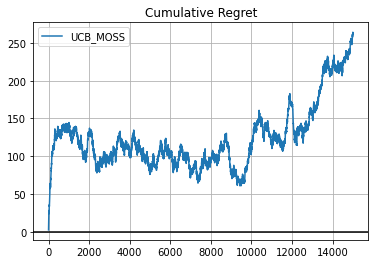

In [854]:
n_rounds = 15000
n_iterations = 10
all_regrets = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.5)[0]
cum_regret_plot([np.arange(1, n_rounds + 1)], [all_regrets.mean(axis = 0)], labels = ['UCB_MOSS'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:43<00:00,  4.40s/it]


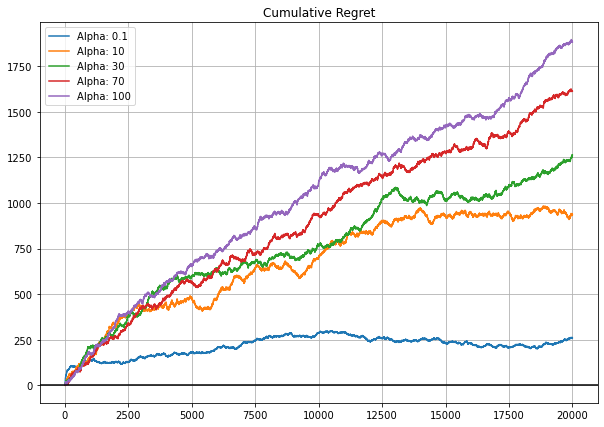

In [855]:
n_rounds = 20000
n_iterations = 10
concs = [0.1, 10, 30, 70, 100]
labels = [f'Alpha: {i}' for i in concs]
x = []
y = []

for conc in concs:
    all_regrets = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Bernoulli

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:52<00:00,  2.60s/it]


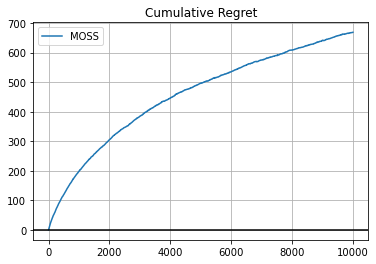

In [860]:
n_rounds = 10000
n_iterations = 20
dist = 'Bernoulli'
all_regrets = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)[0]
cum_regret_plot([np.arange(n_rounds)], [all_regrets.mean(axis = 0)], ['MOSS'])

## Poisson

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s]


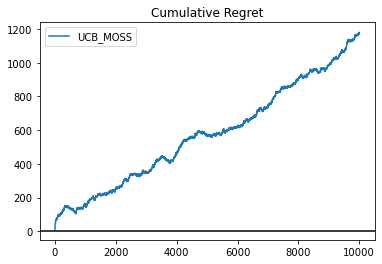

In [365]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(1,11,1)
all_regrets = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
cum_regret_plot([np.arange(1, 1 + n_rounds)], [all_regrets.mean(axis = 0)], labels = ['UCB_MOSS'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


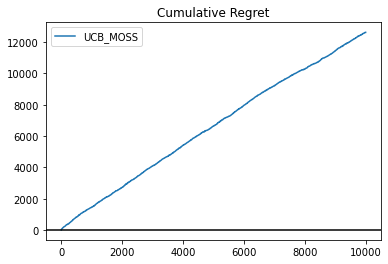

In [371]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(10,21,1)
all_regrets = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
cum_regret_plot([np.arange(1, 1 + n_rounds)], [all_regrets.mean(axis = 0)], labels = ['UCB_MOSS'])

## Exponential

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.26it/s]


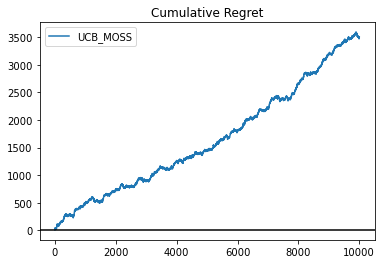

In [367]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(1,11,1)
all_regrets = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
cum_regret_plot([np.arange(1, 1 + n_rounds)], [all_regrets.mean(axis = 0)], labels = ['UCB_MOSS'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.15s/it]


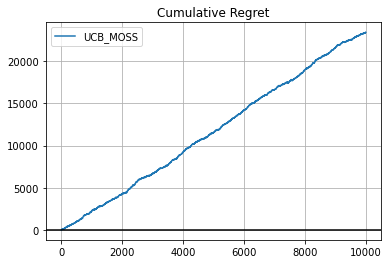

In [789]:
n_arms = 10
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(10,21,1)
all_regrets = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
cum_regret_plot([np.arange(1, 1 + n_rounds)], [all_regrets.mean(axis = 0)], labels = ['UCB_MOSS'])

# KL-UCB

## KL Analysis - Bernoulli

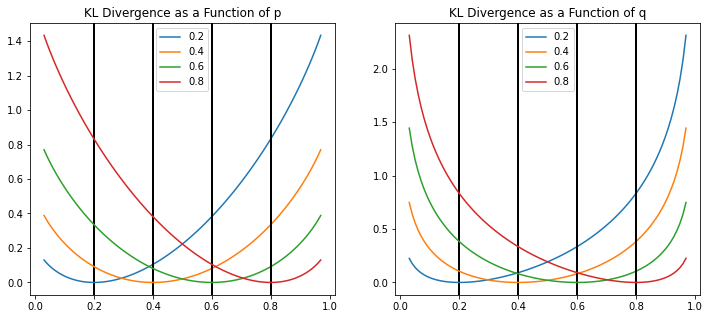

In [17]:
def kl_bern(p, q):
    return p*(np.log(p/q)) + (1-p)*np.log((1-p)/(1-q))

plt.figure(figsize = (12, 5))

plt.subplot(1,2,1)
x = np.arange(0.03, 0.98, 0.01)
y = np.zeros(shape = len(x))
q_s = [0.2, 0.4, 0.6, 0.8]
for q_1 in q_s:
    for i in range(len(x)):
        y[i] = kl_bern(x[i], q_1)
        plt.axvline(q_1, color = 'black')
    plt.plot(x, y, label = q_1)
    plt.legend()
plt.title('KL Divergence as a Function of p')
#plt.show()

plt.subplot(1,2,2)
x = np.arange(0.03, 0.98, 0.01)
y = np.zeros(shape = len(x))
p_s = [0.2, 0.4, 0.6, 0.8]
for p_1 in p_s:
    for i in range(len(x)):
        y[i] = kl_bern(p_1, x[i])
        plt.axvline(p_1, color = 'black')
    plt.plot(x, y, label = p_1)
    plt.legend()
plt.title('KL Divergence as a Function of q')
plt.show()

In [16]:
# Newton-Rhapson Method

def kl_bern_first(p, q):
    return -p*q + (1-p)/(1-q)
def kl_bern_second(p, q):
    return p/q**2 + (1-p)/(1-q)**2

def growth_analysis(q0, p, l_rate, max_iter, t, s = 1):
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    n = 0
    q_s = []
    kls = []
    constraint = np.log(t)
    current = 0
    while q0 > 0 and q0 < 1 and n < max_iter and current < constraint:
        q_s.append(q0)
        current = s*kl_bern(p, q0)
        kls.append(current)
        increment = l_rate*kl_bern_first(p, q0)/kl_bern_second(p, q0)
        q_t = q0 + increment
        q0 = q_t
        n += 1
    plt.plot(q_s, kls)
    plt.title('Growth of KL')

    plt.subplot(1,2,2)
    x = np.arange(0.01, 1, 0.01)
    y = np.zeros(shape = len(x))
    for i in range(len(x)):
        y[i] = s*kl_bern(p, x[i])
    plt.plot(x, y, label = f'p = {p}')
    plt.scatter(q_s, kls, color = 'red', label = 'Growth')
    plt.axhline(constraint, color = 'black', label = 'Constraint')
    plt.title('KL and Growth')
    plt.legend()
    plt.show()
    return q0

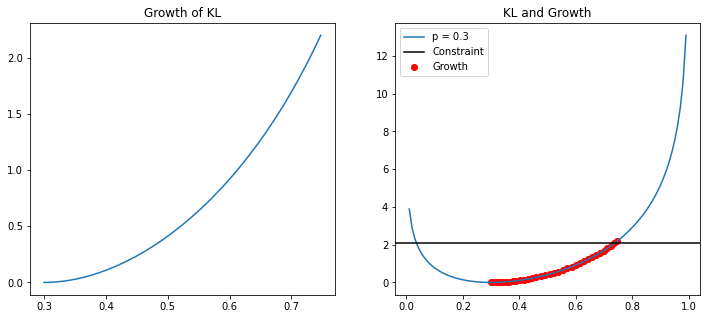

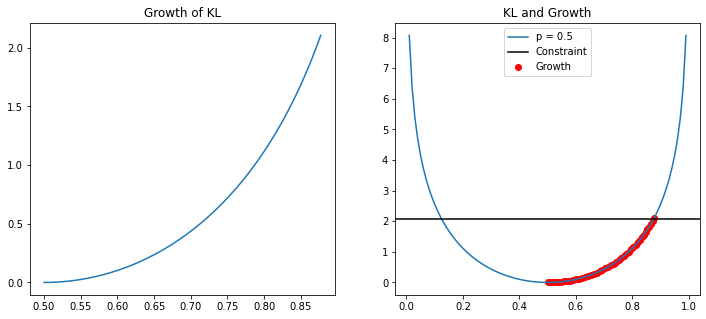

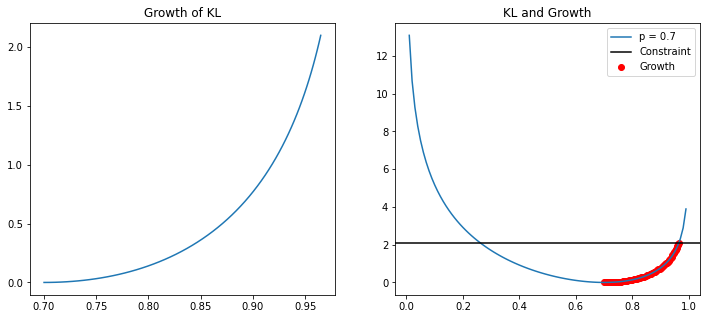

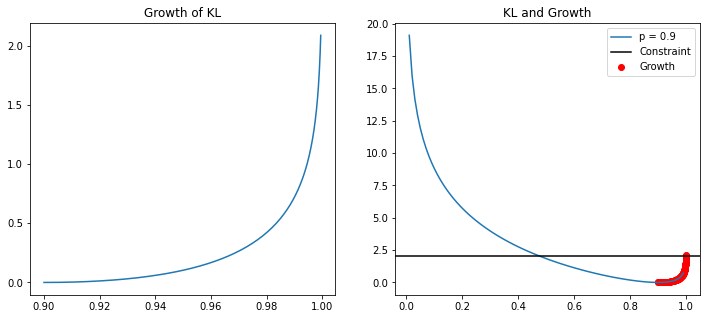

In [123]:
p_s = [0.3, 0.5, 0.7, 0.9]
for p in p_s:
    growth_analysis(q0 = p, p = p, l_rate = 0.05, max_iter = 30000, t = 8, s = 5)

In [15]:
def kl_bern_max(q0, p, l_rate, max_iter, t, s):
    n = 0
    q_s = []
    kls = []
    constraint = np.log(t)
    current = 0
    while q0 > 0 and q0 < 1 and n < max_iter and current < constraint:
        q_s.append(q0)
        current = s*kl_bern(p, q0)
        kls.append(current)
        #increment = l_rate*kl_bern_first(p, q0)/kl_bern_second(p, q0)
        increment = 0.05
        q_t = q0 + increment
        q0 = q_t
        n += 1
    return q_t

## KL Analysis - Poisson

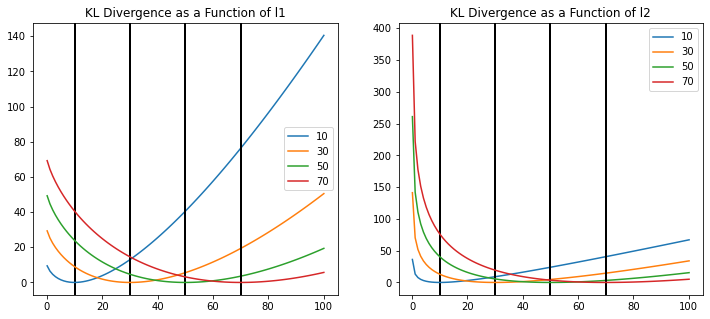

In [14]:
def kl_pois(l1, l2):
    return l2 - l1 + l1*np.log(l1/l2)

plt.figure(figsize = (12, 5))

plt.subplot(1,2,1)
x = np.arange(0.1, 101)
y = np.zeros(shape = len(x))
l2_s = [10, 30, 50, 70]
for l2 in l2_s:
    for i in range(len(x)):
        y[i] = kl_pois(x[i], l2 = l2)
        plt.axvline(l2, color = 'black')
    plt.plot(x, y, label = l2)
    plt.legend()
plt.title('KL Divergence as a Function of l1')
#plt.show()

plt.subplot(1,2,2)
x = np.arange(0.1, 101)
y = np.zeros(shape = len(x))
l1_s = [10, 30, 50, 70]
for l1 in l1_s:
    for i in range(len(x)):
        y[i] = kl_pois(l1, x[i])
        plt.axvline(l1, color = 'black')
    plt.plot(x, y, label = l1)
    plt.legend()
plt.title('KL Divergence as a Function of l2')
plt.show()

In [13]:
# Newton-Rhapson Method

def kl_pois_first(l1, l2):
    return -l1/l2 + 1 - l1
def kl_pois_second(l1, l2):
    return l1/l2**2

def growth_analysis(l0, l1, l_rate, max_iter, t, upper_bound, s = 1):
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    start = l0
    n = 0
    l_s = []
    kls = []
    constraint = np.log(t)
    current = 0
    while l0 > 0 and l0 < upper_bound  and n < max_iter and current < constraint:
        l_s.append(l0)
        current = s*kl_pois(l1, l0)
        kls.append(current)
        #increment = l_rate*kl_pois_first(l1, l0)/kl_pois_second(l1, l0)
        increment = 0.5
        l0 = l0 + increment
        n += 1
    plt.plot(l_s, kls)
    plt.axhline(constraint, color = 'black', label = 'Constraint')
    plt.title('Growth of KL')

    plt.subplot(1,2,2)
    x = np.arange(start - 10, np.max(l_s) + 10, 0.1)
    y = np.zeros(shape = len(x))
    for i in range(len(x)):
        y[i] = s*kl_pois(l1, x[i])
    plt.plot(x, y, label = f'l1 = {l1}')
    plt.scatter(l_s, kls, color = 'red', label = 'Growth')
    plt.axhline(constraint, color = 'black', label = 'Constraint')
    plt.title('KL and Growth')
    plt.legend()
    plt.show()
    return l0

<ipython-input-48-7384e0904dbb>:2: RuntimeWarning: divide by zero encountered in scalar divide
  return l2 - l1 + l1*np.log(l1/l2)


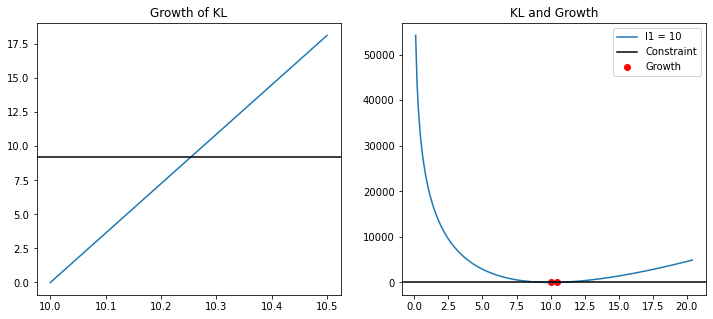

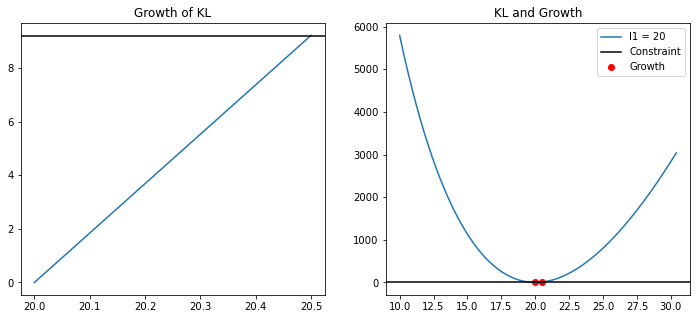

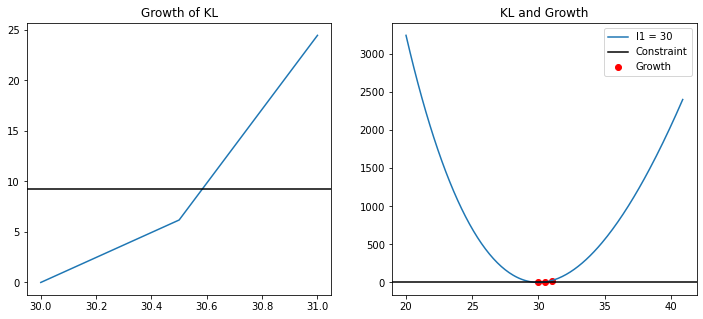

In [756]:
l1_s = [10,20,30]
for l1 in l1_s:
    growth_analysis(l0 = l1, l1 = l1, l_rate = 0.0001, max_iter = 30000, t = 10000, s = 1500, upper_bound = l1 + 20)

In [18]:
def kl_pois_max(l0, l1, l_rate, max_iter, t, s, upper_bound):
    n = 0
    l_s = []
    kls = []
    constraint = np.log(t)
    current = 0
    while l0 > 0 and l0 < upper_bound  and n < max_iter and current < constraint:
        l_s.append(l0)
        current = s*kl_pois(l1, l0)
        kls.append(current)
        #increment = l_rate*kl_pois_first(l1, l0)/kl_pois_second(l1, l0)
        increment = 0.5
        l0 = l0 + increment
        n += 1
    return l0

## KL Analysis - Exponential

In [19]:
# Newton-Rhapson Method
def kl_exp(b1, b2):
    return b1/b2 - 1 - np.log(b1/b2)

def kl_exp_first(b1, b2):
    return -b1/b2**2 + 1/b2

def kl_exp_second(b1, b2):
    return 2*b1/b2**3 - 1/b2**2

def kl_exp_max(l0, l1, l_rate, max_iter, t, upper_bound, s):
    n = 0
    constraint = np.log(t)
    current = 0
    while l0 > 0 and l0 < upper_bound  and n < max_iter and current < constraint:
        if l0 == 0:
            l0 = 0.01
        current = s*kl_exp(l1, l0)
        #increment = l_rate*kl_exp_first(l1, l0)/kl_exp_second(l1, l0)
        increment = 0.5
        l0 +=  increment
        n += 1
    return l0

## Regret Simulation

In [20]:
class ucb_kl_player(player):
    def __init__(self, n_arms, dist):
        super().__init__(n_arms)
        self.dist = dist
        self.ucbs = np.zeros(shape = n_arms)
        
    def compute_ucbs(self, current_round, l_rate, max_iter):
        if self.dist == 'Bernoulli':
            for i in range(self.n_arms):
                if self.means[i] == 0:
                    self.means[i] = 0.01
                if self.means[i] == 1:
                    self.means[i] = 0.99
                maximizer = kl_bern_max(q0 = self.means[i], p = self.means[i], l_rate = l_rate, max_iter = max_iter, t = current_round, s = self.n_trials[i])
                self.ucbs[i] = maximizer
                
        elif self.dist == 'Poisson':
            for i in range(self.n_arms):
                if self.means[i] == 0:
                    self.means[i] = 0.01
                maximizer = kl_pois_max(l0 = self.means[i], l1 = self.means[i], l_rate = l_rate, max_iter = max_iter, t = current_round, s = self.n_trials[i], upper_bound = 1000)
                self.ucbs[i] = maximizer
        
        elif self.dist == 'Exponential':
            for i in range(self.n_arms):
                if self.means[i] == 0:
                    self.means[i] = 0.01
                maximizer = kl_exp_max(l0 = self.means[i] + 1, l1 = self.means[i], l_rate = l_rate, max_iter = max_iter, t = current_round, s = self.n_trials[i], upper_bound = 1000)
                self.ucbs[i] = maximizer
            
    def choice(self):
        choice = np.argmax(self.ucbs)
        self.choices.append(choice)
        return choice

In [21]:
def ucb_kl_experiment_generation(n_rounds, n_iterations, dist, l_rate, max_iter, lambdas = None):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = ucb_kl_player(n_arms = env.n_arms, dist = dist)
            
        elif dist == 'Poisson' or dist == 'Exponential':
            player_1 = ucb_kl_player(n_arms = len(lambdas), dist = dist)
            
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
            else:
                player_1.compute_ucbs(i, l_rate = l_rate, max_iter = max_iter)
                choice = player_1.choice()
                
            if dist == 'Dirichlet' or dist == 'Bernoulli':
                choices_rank.append(ranked_means.index(env.all_means[choice]))
            
            if dist == 'Bernoulli':
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                
            elif dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            player_1.update_regret(reward, best_reward = best_reward)
        all_regrets[j, :] = player_1.cumulative_regrets
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
        
    return all_regrets, all_choices

### Bernoulli

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [02:03<00:00, 12.35s/it]


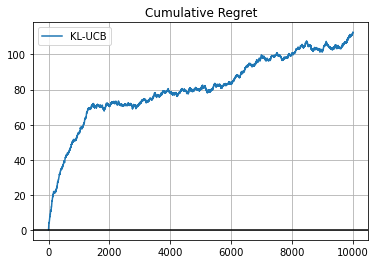

In [863]:
n_rounds = 10000
n_iterations = 10
all_regrets = ucb_kl_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = 'Bernoulli', l_rate = 0.2, max_iter = 10000)[0]
cum_regret_plot([np.arange(1, n_rounds + 1)], [all_regrets.mean(axis = 0)], labels = ['KL-UCB'])

### Poisson

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.99s/it]


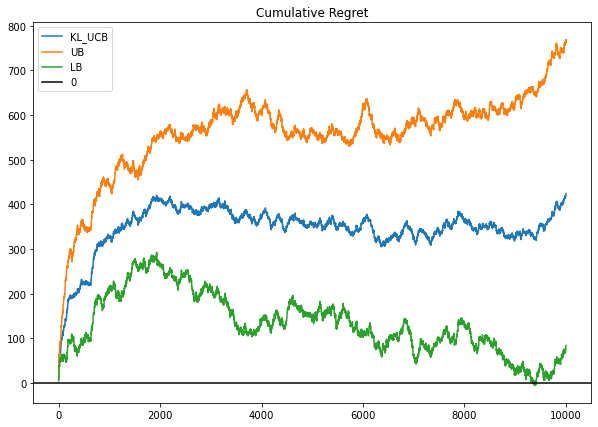

In [751]:
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(1,11,1)
l_rate = 0.05

all_regrets = ucb_kl_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist,  l_rate = l_rate, max_iter = 5000, lambdas = lambdas)[0]
plt.figure(figsize = (10,7))
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0), label = 'KL_UCB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) + all_regrets.std(axis = 0), label = 'UB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) - all_regrets.std(axis = 0), label = 'LB')
plt.axhline(0, color = 'black', label = '0')
plt.legend()
plt.title('Cumulative Regret')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:32<00:00,  9.27s/it]


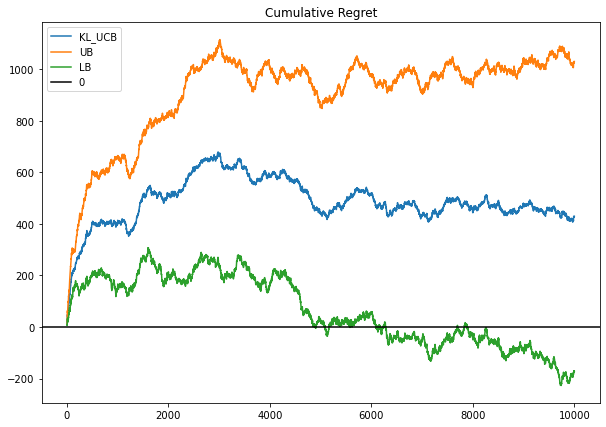

In [752]:
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(10,21,1)
l_rate = 0.005

all_regrets = ucb_kl_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist,  l_rate = l_rate, max_iter = 5000, lambdas = lambdas)[0]
plt.figure(figsize = (10,7))
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0), label = 'KL_UCB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) + all_regrets.std(axis = 0), label = 'UB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) - all_regrets.std(axis = 0), label = 'LB')
plt.axhline(0, color = 'black', label = '0')
plt.legend()
plt.title('Cumulative Regret')
plt.show()

### Exponential

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:57<00:00,  5.80s/it]


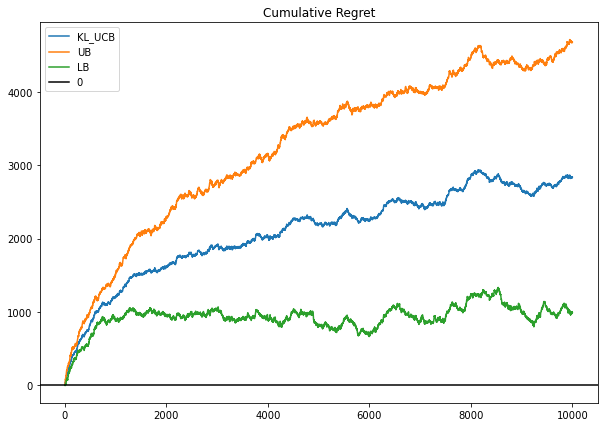

In [729]:
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(1,11,1)
l_rate = 0.01

all_regrets = ucb_kl_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist,  l_rate = l_rate, max_iter = 5000, lambdas = lambdas)[0]
plt.figure(figsize = (10,7))
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0), label = 'KL_UCB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) + all_regrets.std(axis = 0), label = 'UB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) - all_regrets.std(axis = 0), label = 'LB')
plt.axhline(0, color = 'black', label = '0')
plt.grid()
plt.legend()
plt.title('Cumulative Regret')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:39<00:00,  9.97s/it]


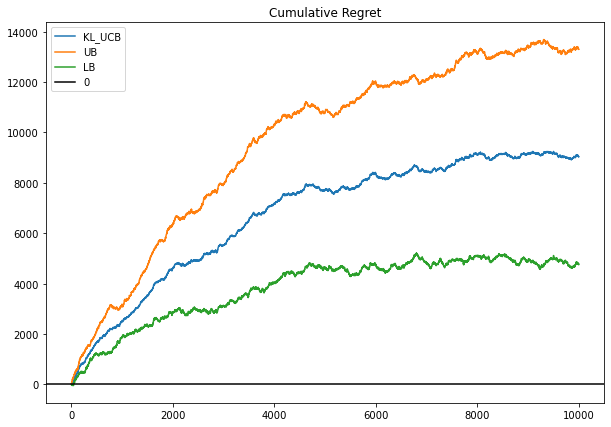

In [730]:
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(10,21,1)
l_rate = 0.05

all_regrets = ucb_kl_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist,  l_rate = l_rate, max_iter = 5000, lambdas = lambdas)[0]
plt.figure(figsize = (10,7))
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0), label = 'KL_UCB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) + all_regrets.std(axis = 0), label = 'UB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) - all_regrets.std(axis = 0), label = 'LB')
plt.axhline(0, color = 'black', label = '0')
plt.grid()
plt.legend()
plt.title('Cumulative Regret')
plt.show()

# Epsilon-Greedy

In [5]:
def decay_prob(d):
    return lambda t: (t**(d))*((10*np.log(t))**(1/3))

In [3]:
class eps_player(player):
    def __init__(self, n_arms, prob):
        super().__init__(n_arms)
        self.exps = []
        self.prob = prob
        
    def exp_vs_exp(self, current_round):
        if type(self.prob) == float:
            eps = self.prob
        else:
            eps = self.prob(current_round)
        u = np.random.uniform(0,1)
        if u <= eps:
            self.exps.append('Exploration')
            return 'Exploration'
        else:
            self.exps.append('Exploitation')
            return 'Exploitation'
        
    def choice(self, exp):
        if exp == 'Exploration':
            choice = np.random.choice(np.arange(self.n_arms))
        else:
            choice = np.argmax(self.means)
        self.choices.append(choice)
        return choice

In [4]:
def eps_experiment_generation(n_rounds, n_iterations, prob, dist = 'Dirichlet', lambdas = None, conc = None):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Dirichlet':
            env = env_generation(n_arms = 10, n_variables = 10, conc = conc)
            ranked_means = sorted(env.all_means)
            player_1 = eps_player(env.n_arms, prob = prob)
        elif dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = eps_player(env.n_arms, prob = prob)
        elif dist == 'Poisson' or dist == 'Exponential':
            player_1 = eps_player(len(lambdas), prob = prob)
            
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
            else:
                exp = player_1.exp_vs_exp(i)
                choice = player_1.choice(exp)
            
            if dist == 'Dirichlet' or dist == 'Bernoulli':
                choices_rank.append(ranked_means.index(env.all_means[choice]))
                
            if dist == 'Dirichlet' or dist == 'Bernoulli':
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                
            elif dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            player_1.update_regret(reward, best_reward = best_reward)
        all_regrets[j, :] = player_1.cumulative_regrets
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
        
    return all_regrets, all_choices

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.21s/it]


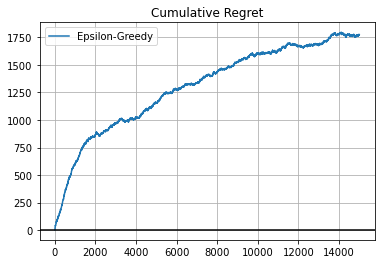

In [13]:
n_rounds = 15000
n_iterations = 10
all_regrets = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.5, prob = 0.02)[0]
cum_regret_plot([np.arange(1, n_rounds + 1)], [all_regrets.mean(axis = 0)], labels = ['Epsilon-Greedy'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:31<00:00,  3.18s/it]


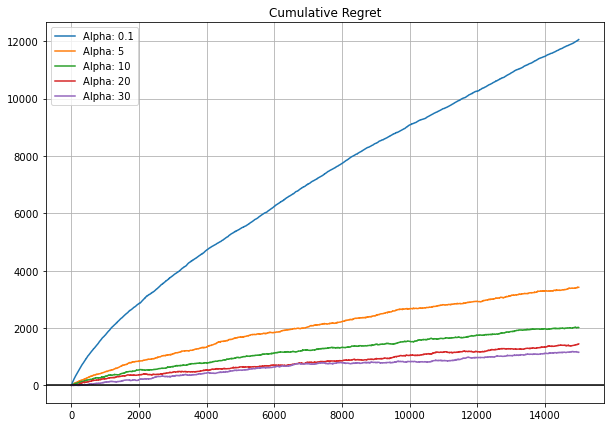

In [825]:
n_rounds = 15000
n_iterations = 10
concs = [0.1, 5, 10, 20, 30]
labels = [f'Alpha: {i}' for i in concs]
x = []
y = []

for conc in concs:
    all_regrets = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Poisson

In [ ]:
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(1,11,1)
x = np.arange(1, 1 + n_rounds)
all_regrets = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
plt.figure(figsize = (8,5))
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0), label = 'Epsilon-Greedy')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) + all_regrets.std(axis = 0), label = 'UB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) - all_regrets.std(axis = 0), label = 'LB')
plt.plot(np.arange(1, 1 + n_rounds), [(x[i]**(2/3))*((10*np.log(x[i]))**(1/3)) for i in range(len(x))], label = 'Regret Bound')
plt.axhline(0, color = 'black', label = '0')
plt.legend()
plt.title('Cumulative Regret')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.57it/s]


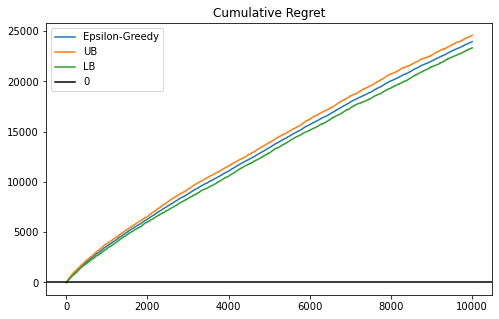

In [223]:
n_rounds = 10000
n_iterations = 10
dist = 'Poisson'
lambdas = np.arange(10,21,1)

all_regrets = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
plt.figure(figsize = (8,5))
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0), label = 'Epsilon-Greedy')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) + all_regrets.std(axis = 0), label = 'UB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) - all_regrets.std(axis = 0), label = 'LB')
plt.axhline(0, color = 'black', label = '0')
plt.legend()
plt.title('Cumulative Regret')
plt.show()

## Exponential

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


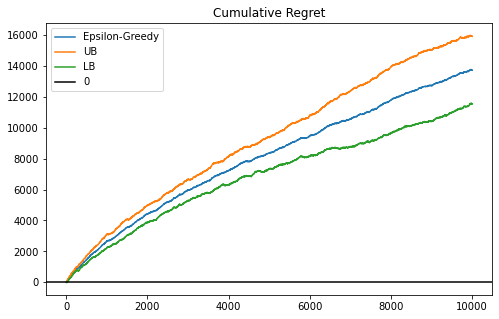

In [224]:
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(1,11,1)

all_regrets = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
plt.figure(figsize = (8,5))
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0), label = 'Epsilon-Greedy')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) + all_regrets.std(axis = 0), label = 'UB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) - all_regrets.std(axis = 0), label = 'LB')
plt.axhline(0, color = 'black', label = '0')
plt.legend()
plt.title('Cumulative Regret')
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.42it/s]


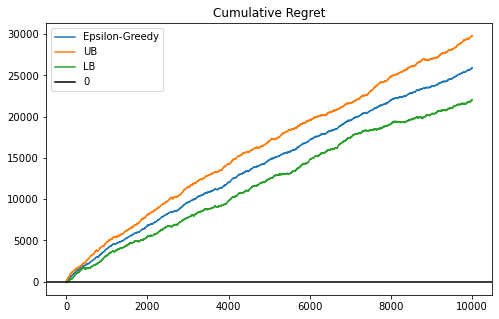

In [225]:
n_rounds = 10000
n_iterations = 10
dist = 'Exponential'
lambdas = np.arange(10,21,1)

all_regrets = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]
plt.figure(figsize = (8,5))
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0), label = 'Epsilon-Greedy')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) + all_regrets.std(axis = 0), label = 'UB')
plt.plot(np.arange(1, 1 + n_rounds), all_regrets.mean(axis = 0) - all_regrets.std(axis = 0), label = 'LB')
plt.axhline(0, color = 'black', label = '0')
plt.legend()
plt.title('Cumulative Regret')
plt.show()

# Bayes UCB

In [13]:
class bayes_player(player):
    def __init__(self, n_arms, dist, shape = 1, scale = 1):
        super().__init__(n_arms)
        self.ucbs = np.zeros(shape = n_arms)
        self.dist = dist
        self.a = np.ones(shape = n_arms)
        self.b = np.ones(shape = n_arms)
        self.shape = np.array([shape for i in range(n_arms)])
        if dist == 'Exponential' or dist == 'Poisson':
            self.scale = [1/scale for i in range(n_arms)]
        else:
            self.scale = [scale for i in range(n_arms)]
        self.all_samples = np.zeros(shape  = (n_arms, 1000))
                
    def choice(self):
        choice = np.argmax(self.ucbs)
        self.choices.append(choice)
        return choice
    
    def compute_ucbs(self, current_round):
        if self.dist == 'Bernoulli':
            for i in range(self.n_arms):
                self.ucbs[i] = np.quantile(self.all_samples[i, :], q = 1 - 1/current_round)
        elif self.dist == 'Poisson':
            for i in range(self.n_arms):
                self.ucbs[i] = np.quantile(self.all_samples[i, :], q = 1 - 1/current_round)
        elif self.dist == 'Exponential':
            for i in range(self.n_arms):
                self.ucbs[i] = np.quantile(self.all_samples[i, :], q = 1 - 1/current_round)
    
    def update_params(self, choice, reward):
        if self.dist == 'Bernoulli':
            if reward == 0:
                self.b[choice] += 1
            else:
                self.a[choice] += 1
            self.all_samples[choice, :] = np.random.beta(a = self.a[choice], b = self.b[choice], size = 1000)

        elif self.dist == 'Poisson':
            self.shape[choice] += reward
            self.scale[choice] += 1
            #self.scale[choice] = float(self.scale[choice]/(self.scale[choice] + 1))
            #self.all_samples[choice, :] = np.random.negative_binomial(self.shape[choice], 1/(self.scale[choice] + 1), size = 1000)
            self.all_samples[choice, :] = np.random.gamma(shape = self.shape[choice], scale = 1/self.scale[choice], size = 1000)
        elif self.dist == 'Exponential':
            self.shape[choice] += 1
            self.scale[choice] += reward
            #self.all_samples[choice, :] = lomax.rvs(c = self.shape[choice], scale = self.scale[choice], size = 1000)
            self.all_samples[choice, :] = np.random.gamma(shape = self.shape[choice], scale = 1/self.scale[choice], size = 1000)

In [11]:
def bayes_experiment_generation(n_rounds, n_iterations, dist, lambdas = None, shape = 1, scale = 1):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = bayes_player(n_arms = env.n_arms, dist = dist)
        elif dist == 'Poisson' or dist == 'Exponential':
            player_1 = bayes_player(n_arms = len(lambdas), dist = dist, shape = shape, scale = scale)
        
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
            else:
                player_1.compute_ucbs(i)
                choice = player_1.choice()
            
            if dist == 'Dirichlet' or dist == 'Bernoulli':
                choices_rank.append(ranked_means.index(env.all_means[choice]))
                
            if dist == 'Bernoulli':
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                
            if dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
                
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            player_1.update_params(choice, reward)
            player_1.update_regret(reward, best_reward)
        all_regrets[j, :] = player_1.cumulative_regrets
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
        
    return all_regrets, all_choices

## Bernoulli

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:06<00:00, 42.60s/it]


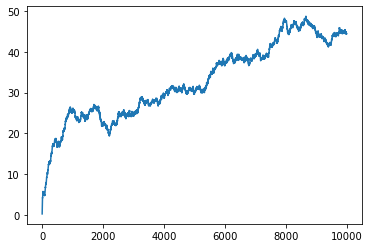

In [935]:
n_iterations = 10
n_rounds = 10000
dist = 'Bernoulli'

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

In [939]:
n_iterations = 50
n_rounds = 100000
dist = 'Bernoulli'

all_regrets, all_choices = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)

data = pd.DataFrame()
data['ucbbayes_regrets'] = all_regrets.mean(axis = 0)
data['ucbbayes_choice'] = all_choices
data['ucbbayes_stds'] = all_regrets.std(axis = 0)
data.to_csv('Bayes_Bernoulli.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [6:04:15<00:00, 437.12s/it]


## Poisson

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:44<00:00, 28.50s/it]


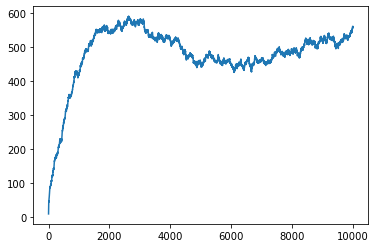

In [14]:
n_iterations = 10
n_rounds = 10000
dist = 'Poisson'
lambdas = np.arange(1,11,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [06:20<00:00, 38.06s/it]


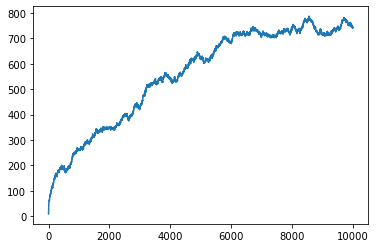

In [18]:
n_iterations = 10
n_rounds = 10000
dist = 'Poisson'
lambdas = np.arange(1,11,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas, scale = 1, shape = 5)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

In [940]:
n_iterations = 50
n_rounds = 100000
dist = 'Poisson'
lambdas = np.arange(1,11,1)

all_regrets, all_choices = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)

data = pd.DataFrame()
data['ucbbayes_regrets'] = all_regrets.mean(axis = 0)
data['ucbbayes_choice'] = all_choices
data['ucbbayes_stds'] = all_regrets.std(axis = 0)
data.to_csv('Bayes_Poisson_1.csv')

100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [7:52:48<00:00, 567.37s/it]


100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [19:05<00:00, 114.53s/it]


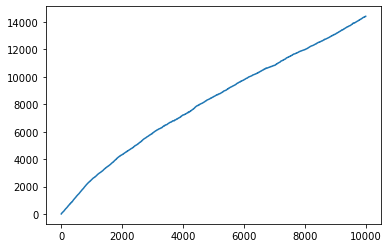

In [104]:
n_iterations = 10
n_rounds = 10000
dist = 'Poisson'
lambdas = np.arange(10,21,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:27<00:00, 32.76s/it]


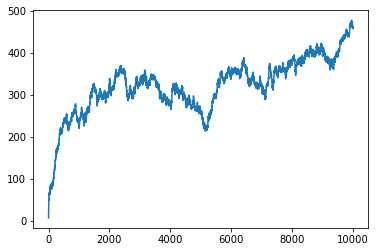

In [15]:
n_iterations = 10
n_rounds = 10000
dist = 'Poisson'
lambdas = np.arange(10,21,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas, scale = 1, shape = 15)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

## Exponential

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:16<00:00, 16.81s/it]


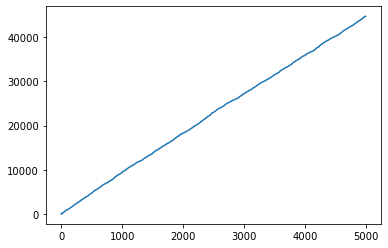

In [16]:
n_iterations = 1
n_rounds = 5000
dist = 'Exponential'
lambdas = np.arange(1,11,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:58<00:00, 44.92s/it]


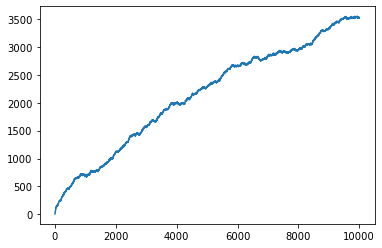

In [56]:
n_iterations = 20
n_rounds = 10000
dist = 'Exponential'
lambdas = np.arange(1,11,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [13:08<00:00, 39.43s/it]


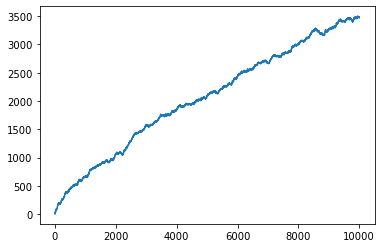

In [57]:
n_iterations = 20
n_rounds = 10000
dist = 'Exponential'
lambdas = np.arange(1,11,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas, scale = 5, shape = 1)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:38<00:00, 33.88s/it]


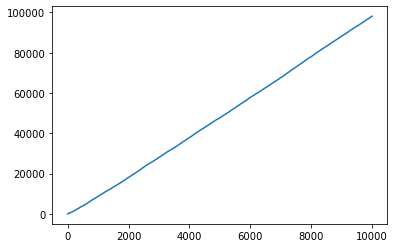

In [17]:
n_iterations = 10
n_rounds = 10000
dist = 'Exponential'
lambdas = np.arange(10,21,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [14:56<00:00, 44.81s/it]


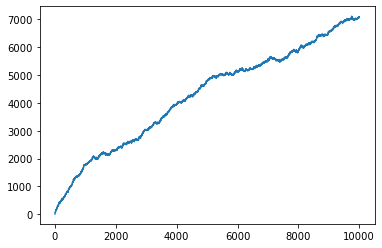

In [59]:
n_iterations = 20
n_rounds = 10000
dist = 'Exponential'
lambdas = np.arange(10,21,1)

all_regrets = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas, scale = 15, shape = 1)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

# Thompson Sampling

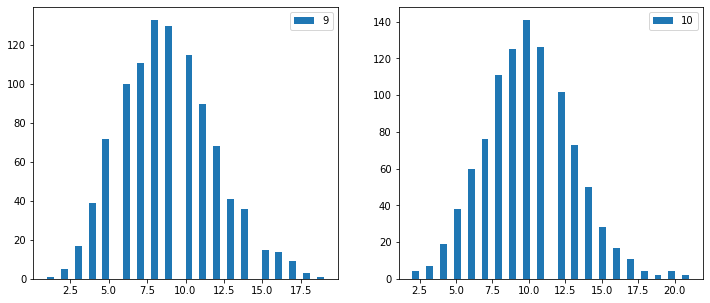

In [36]:
# Poisson
sample_9 = np.random.poisson(lam = 9, size = 1000)
sample_10 = np.random.poisson(lam = 10, size = 1000)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.hist(sample_9, bins = 40, label = '9')
plt.legend()
plt.subplot(1,2,2)
plt.hist(sample_10, bins = 40, label = '10')
plt.legend()
plt.show()

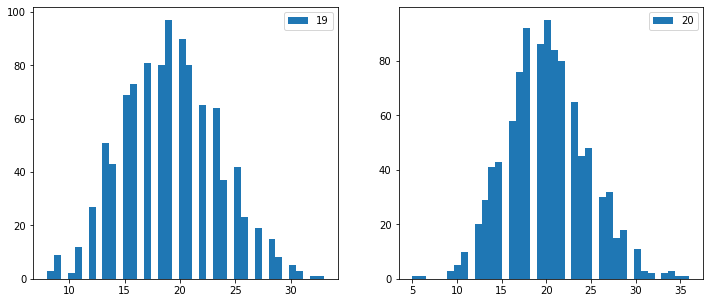

In [38]:
# Poisson
sample_19 = np.random.poisson(lam = 19, size = 1000)
sample_20 = np.random.poisson(lam = 20, size = 1000)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.hist(sample_19, bins = 40, label = '19')
plt.legend()
plt.subplot(1,2,2)
plt.hist(sample_20, bins = 40, label = '20')
plt.legend()
plt.show()

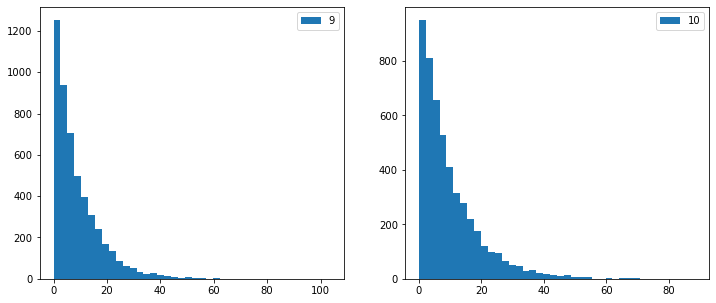

In [42]:
# Exponential
sample_9 = np.random.exponential(scale = 9, size = 5000)
sample_10 = np.random.exponential(scale = 10, size = 5000)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.hist(sample_9, bins = 40, label = '9')
plt.legend()
plt.subplot(1,2,2)
plt.hist(sample_10, bins = 40, label = '10')
plt.legend()
plt.show()

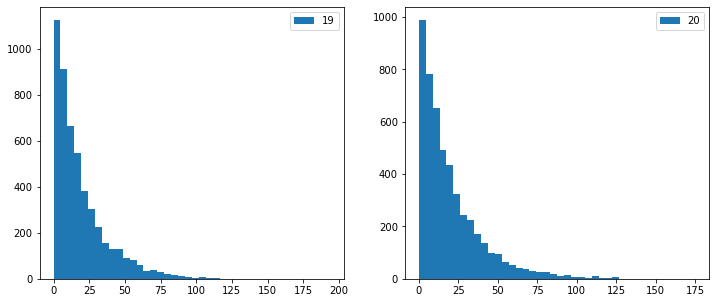

In [41]:
# Exponential
sample_19 = np.random.exponential(scale = 19, size = 5000)
sample_20 = np.random.exponential(scale = 20, size = 5000)
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.hist(sample_19, bins = 40, label = '19')
plt.legend()
plt.subplot(1,2,2)
plt.hist(sample_20, bins = 40, label = '20')
plt.legend()
plt.show()

In [11]:
class thom_player(player):
    def __init__(self, n_arms, dist, lb = 0, ub = 1):
        super().__init__(n_arms)
        self.a = np.ones(shape = n_arms)
        self.b = np.ones(shape = n_arms)
        self.dist = dist
        self.lb = lb
        self.ub = ub
        
    def choice(self):
        samples = [np.random.beta(a = self.a[i], b = self.b[i]) for i in range(self.n_arms)]
        choice = np.argmax(samples)
        self.choices.append(choice)
        return choice
    
    def normalize(self, reward):
        if reward > self.ub:
            self.ub = reward
        elif reward < self.lb:
            self.lb = reward
        reward = (reward - self.lb)/(self.ub - self.lb)
        return reward
    
    def update_params(self, choice, reward):
        if self.dist == 'Bernoulli':
            if reward == 1:
                self.a[choice] += 1
            else:
                self.b[choice] += 1     
        else:
            u = np.random.uniform(0,1)
            if u <= reward:
                self.a[choice] += 1
            else:
                self.b[choice] += 1

In [12]:
def thompson_experiment_generation(n_rounds, n_iterations, dist, lambdas = None, lb = 0, ub = 1, conc = None):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    if dist == 'Exponential':
        ub = np.random.exponential(scale = np.max(lambdas), size = 1000).max()
        lb = np.random.exponential(scale = np.min(lambdas), size = 1000).min()
    elif dist == 'Poisson':
        ub = np.random.poisson(lam = np.max(lambdas), size = 1000).max()
        lb = np.random.poisson(lam = np.min(lambdas), size = 1000).min()
    elif dist == 'Dirichlet':
        ub = 10
        lb = 1
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Dirichlet':
            env = env_generation(n_arms = 10, n_variables = 10, conc = conc)
            ranked_means = sorted(env.all_means)
            player_1 = thom_player(n_arms = env.n_arms, dist = dist, lb = lb, ub = ub)
        elif dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = thom_player(n_arms = env.n_arms, dist = dist, lb = lb, ub = ub)
        elif dist == 'Poisson' or dist == 'Exponential':
            player_1 = thom_player(n_arms = len(lambdas), dist = dist, lb = lb, ub = ub)
        
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
                
            else:
                choice = player_1.choice()
                
            if dist == 'Bernoulli' or dist == 'Dirichlet':
                choices_rank.append(ranked_means.index(env.all_means[choice]))
            
            if dist == 'Bernoulli' or dist == 'Dirichlet':
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                
            if dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
                
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            if dist != 'Bernoulli':
                norm_reward = player_1.normalize(reward)
                player_1.update_params(choice, norm_reward)
            else:
                player_1.update_params(choice, reward)
            player_1.update_regret(reward, best_reward)
            
        all_regrets[j, :] = player_1.cumulative_regrets
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
        
    return all_regrets, all_choices

## Dirichlet

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.68s/it]


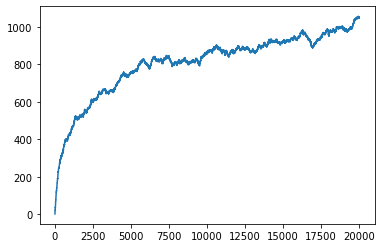

In [19]:
n_iterations = 10
n_rounds = 20000
dist = 'Dirichlet'

all_regrets = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, conc = 0.5)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.76s/it]


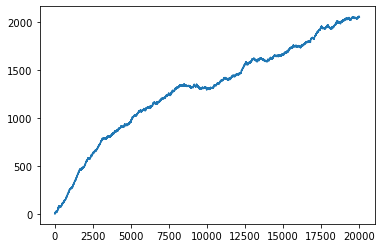

In [24]:
n_iterations = 10
n_rounds = 20000
dist = 'Dirichlet'

all_regrets = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 10, dist = dist)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:33<00:00,  3.33s/it]


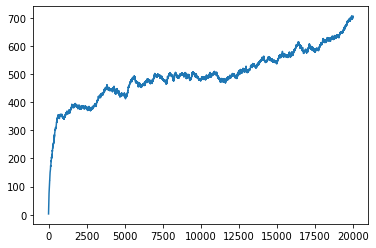

In [25]:
n_iterations = 10
n_rounds = 20000
dist = 'Dirichlet'

all_regrets = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.1, dist = dist)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

## Bernoulli

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:08<00:00,  6.40s/it]


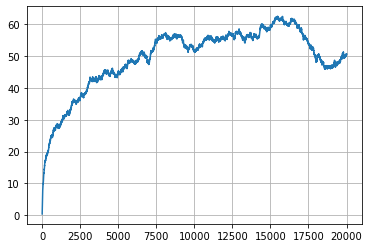

In [14]:
n_iterations = 20
n_rounds = 20000
dist = 'Bernoulli'

all_regrets = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.grid()
plt.show()

## Poisson

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


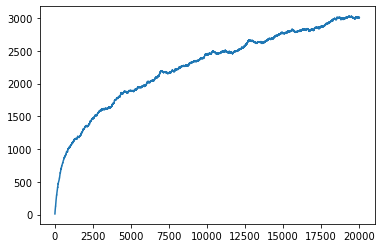

In [20]:
n_iterations = 10
n_rounds = 20000
dist = 'Poisson'
lambdas = np.arange(1,11,1)

all_regrets = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


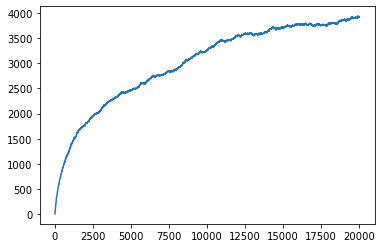

In [21]:
n_iterations = 10
n_rounds = 20000
dist = 'Poisson'
lambdas = np.arange(1,11,1)

all_regrets = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

## Exponential

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:20<00:00,  2.02s/it]


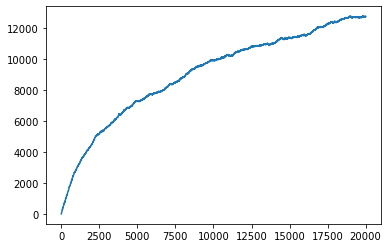

In [22]:
n_iterations = 10
n_rounds = 20000
dist = 'Exponential'
lambdas = np.arange(1,11,1)

all_regrets = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


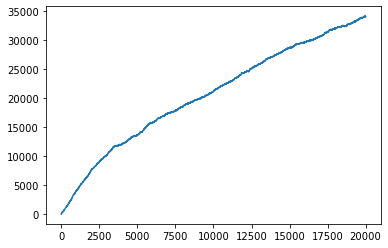

In [23]:
n_iterations = 10
n_rounds = 20000
dist = 'Exponential'
lambdas = np.arange(10,21,1)

all_regrets = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)[0]

plt.plot(np.arange(n_rounds), all_regrets.mean(axis = 0))
plt.show()

# SoftMax Algorithm

In [28]:
class softmax_player(player):
    def __init__(self, n_arms, temp):
        super().__init__(n_arms)
        self.temp = temp
        self.probs = np.zeros(shape = n_arms)
        
    def compute_probs(self):
        den = np.sum(np.exp(self.means/self.temp))
        num = np.exp(self.means/self.temp)
        self.probs = num/den
        
    def choice(self):
        choice = np.random.choice(np.arange(self.n_arms), p = self.probs)
        self.choices.append(choice)
        return choice

In [29]:
def softmax_experiment_generation(n_rounds, n_iterations, temp, dist = 'Dirichlet', lambdas = None, conc = None):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Dirichlet':
            env = env_generation(n_arms = 10, n_variables = 10, conc = conc)
            ranked_means = sorted(env.all_means)
            player_1 = softmax_player(n_arms = env.n_arms, temp = temp)
        elif dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = softmax_player(n_arms = env.n_arms, temp = temp)
        elif dist == 'Poisson' or dist == 'Exponential':
            player_1 = softmax_player(n_arms = len(lambdas),  temp = temp)
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
                
            else:
                player_1.compute_probs()
                choice = player_1.choice()
            
            if dist == 'Bernoulli' or dist == 'Dirichlet':
                choices_rank.append(ranked_means.index(env.all_means[choice]))

            if dist == 'Dirichlet' or dist == 'Bernoulli':
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                
            elif dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            player_1.update_regret(reward, best_reward)
        all_regrets[j, :] = player_1.cumulative_regrets
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
        
    return all_regrets, all_choices

## Dirichlet

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.01s/it]


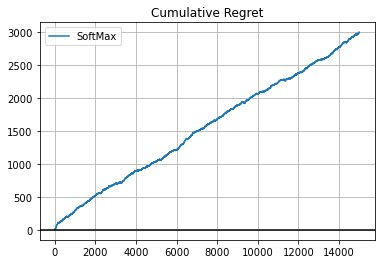

In [880]:
n_rounds = 15000
n_iterations = 10
all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.5, temp = 0.3)[0]
cum_regret_plot([np.arange(1, n_rounds + 1)], [all_regrets.mean(axis = 0)], labels = ['SoftMax'])

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:16<00:00,  3.82s/it]


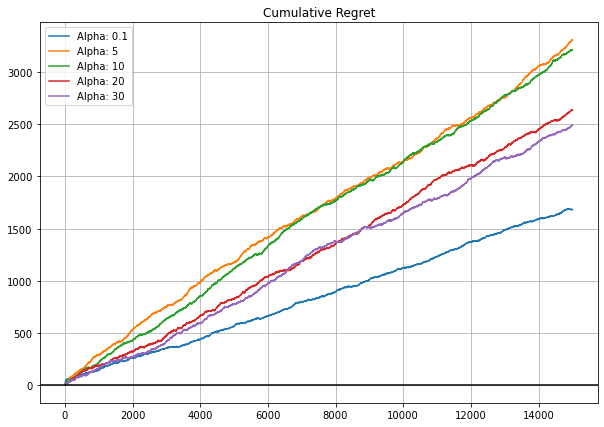

In [881]:
n_rounds = 15000
n_iterations = 20
concs = [0.1, 5, 10, 20, 30]
labels = [f'Alpha: {i}' for i in concs]
x = []
y = []

for conc in concs:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc, temp = 0.3)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.86s/it]


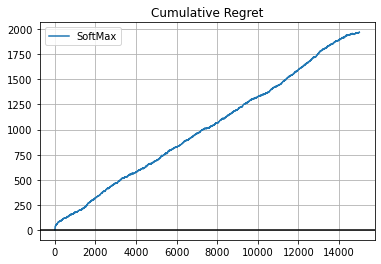

All Means: [0.9081329  0.1815616  0.27044545 0.66392058 0.223395   0.26063264
 0.76278002 0.63161522 0.00573583 0.72964954]


In [882]:
n_rounds = 15000
n_iterations = 20
all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.1, temp = 0.3)[0]
cum_regret_plot([np.arange(1, n_rounds + 1)], [all_regrets.mean(axis = 0)], labels = ['SoftMax'])
print(f'All Means: {env.all_means}')

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:10<00:00,  6.52s/it]


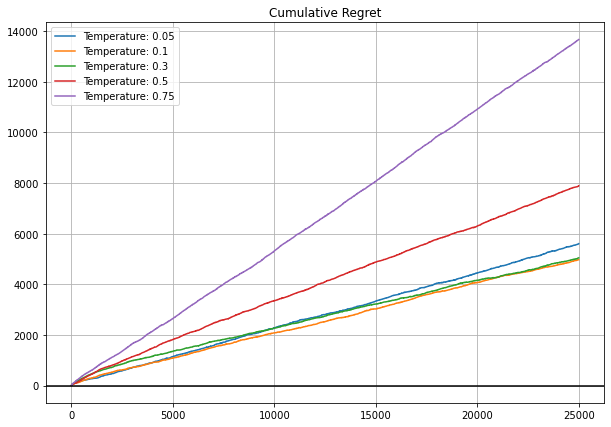

In [34]:
n_rounds = 25000
n_iterations = 20
temps = [0.05, 0.1, 0.3, 0.5, 0.75]
labels = [f'Temperature: {i}' for i in temps]
x = []
y = []

for temp in temps:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.5, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.89s/it]


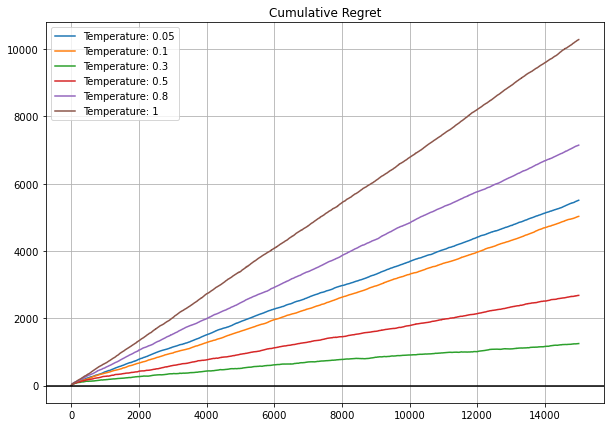

In [884]:
n_rounds = 15000
n_iterations = 20
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]
x = []
y = []

for temp in temps:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.1, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.86s/it]


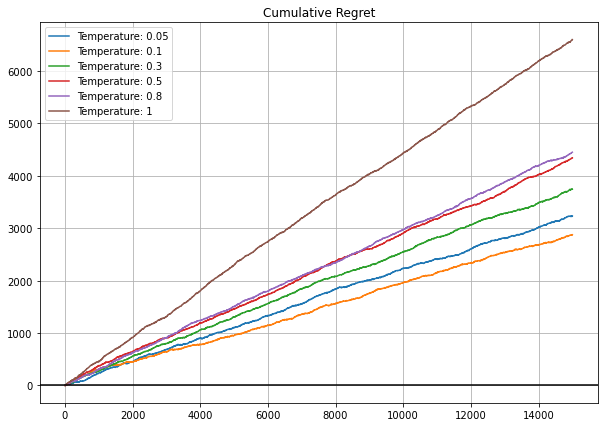

In [885]:
n_rounds = 15000
n_iterations = 20
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]
x = []
y = []

for temp in temps:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 10, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Bernoulli

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:43<00:00,  5.16s/it]


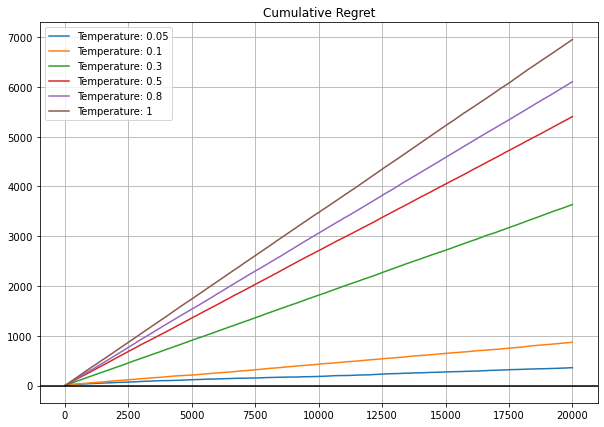

In [888]:
n_iterations = 20
n_rounds = 20000
dist = 'Bernoulli'
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Poisson

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  3.00s/it]


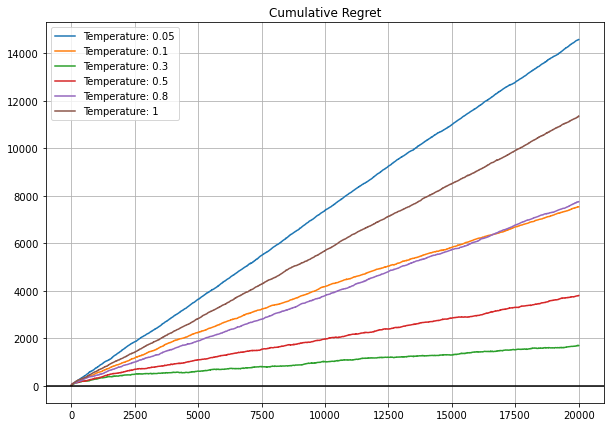

In [760]:
dist = 'Poisson'
lambdas = np.arange(1,11,1)
n_iterations = 20
n_rounds = 20000
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.99s/it]


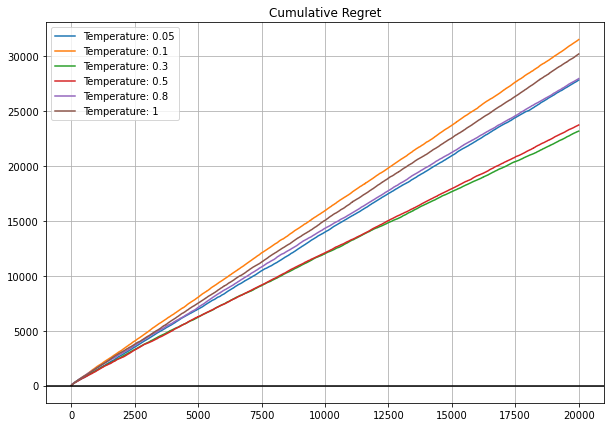

In [761]:
dist = 'Poisson'
lambdas = np.arange(10,21,1)
n_iterations = 20
n_rounds = 20000
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Exponential

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:19<00:00,  3.96s/it]


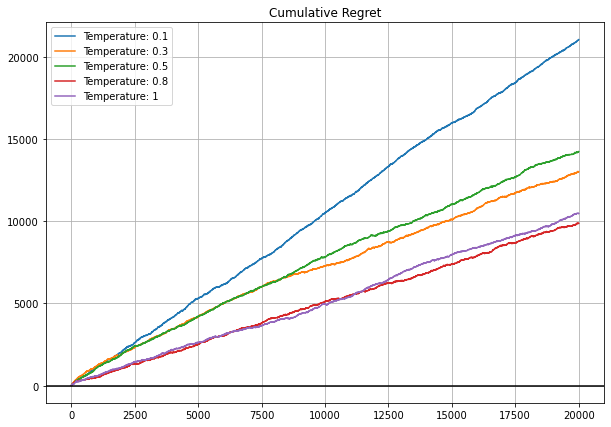

In [782]:
dist = 'Exponential'
lambdas = np.arange(1,11,1)
n_iterations = 20
n_rounds = 20000
temps = [0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [01:47<00:00,  3.58s/it]


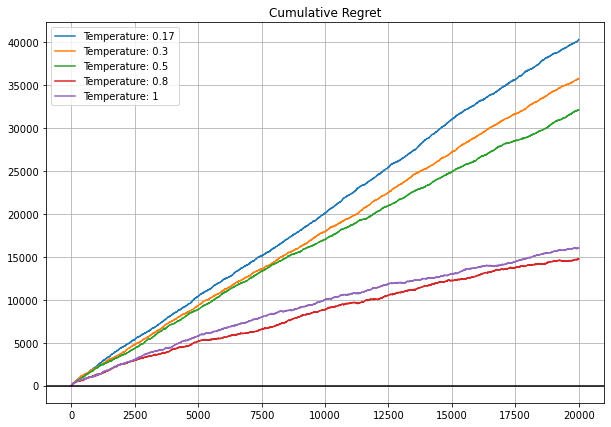

In [17]:
dist = 'Exponential'
lambdas = np.arange(10,21,1)
n_iterations = 30
n_rounds = 20000
temps = [0.17, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

# Epsilon-Greedy/Softmax

In [30]:
class soft_eps_player(eps_player):
    def __init__(self, n_arms, temp):
        super().__init__(n_arms)
        self.temp = temp
        
    def choice(self, exp):
        if exp == 'Exploration':
            den = np.sum(np.exp(self.means/self.temp))
            num = np.exp(self.means/self.temp)
            choice = np.random.choice(np.arange(self.n_arms), p = num/den)
        else:
            choice = np.argmax(self.means)
        self.choices.append(choice)
        return choice

In [31]:
def softmax_eps_experiment_generation(n_rounds, n_iterations, temp, dist = 'Dirichlet', conc = None, lambdas = None):
    all_regrets = np.zeros(shape = (n_iterations, n_rounds))
    all_choices = np.zeros(shape = (n_iterations, n_rounds))
    
    for j in tqdm(range(n_iterations)):
        choices_rank = []
        if dist == 'Dirichlet':
            env = env_generation(n_arms = 10, n_variables = 10, conc = conc)
            ranked_means = sorted(env.all_means)
            player_1 = soft_eps_player(n_arms = env.n_arms, temp = temp)
        elif dist == 'Bernoulli':
            env = env_generation(n_arms = 10, n_variables = 2, dist = dist)
            ranked_means = sorted(env.all_means)
            player_1 = soft_eps_player(n_arms = env.n_arms, temp = temp)
        elif dist == 'Poisson' or dist == 'Exponential':
            player_1 = soft_eps_player(n_arms = len(lambdas),  temp = temp)
            
        for i in range(1, n_rounds + 1):
            if i <= player_1.n_arms:
                choice = i - 1
                player_1.choices.append(choice)
            else:
                exp = player_1.exp_vs_exp(i)
                choice = player_1.choice(exp)
                
            if dist == 'Dirichlet' or dist == 'Bernoulli':
                choices_rank.append(ranked_means.index(env.all_means[choice]))

            if dist == 'Dirichlet' or dist == 'Bernoulli':
                best_reward = np.random.choice(env.rewards, p = env.probs_matrix[env.best_arm, :])
                reward = np.random.choice(env.rewards, p = env.probs_matrix[choice, :])
                
            elif dist == 'Poisson':
                best_reward = np.random.poisson(lam = lambdas[np.argmax(lambdas)])
                reward = np.random.poisson(lam = lambdas[choice])
            elif dist == 'Exponential':
                best_reward = np.random.exponential(scale = lambdas[np.argmax(lambdas)])
                reward = np.random.exponential(scale = lambdas[choice])
                
            player_1.update_n_trials(choice)
            player_1.update_mean(choice, reward)
            player_1.update_regret(reward, best_reward)
        all_regrets[j, :] = player_1.cumulative_regrets
        if dist == 'Dirichlet' or dist == 'Bernoulli':
            all_choices[j, :] = choices_rank
        else:
            all_choices[j, :] = player_1.choices
        
    return all_regrets, all_choices

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:58<00:00,  2.94s/it]


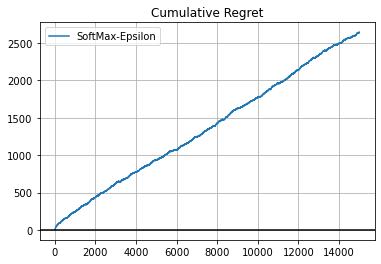

In [890]:
n_rounds = 15000
n_iterations = 20
all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.5, temp = 0.3)[0]
cum_regret_plot([np.arange(1, n_rounds + 1)], [all_regrets.mean(axis = 0)], labels = ['SoftMax-Epsilon'])

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:29<00:00,  2.93s/it]


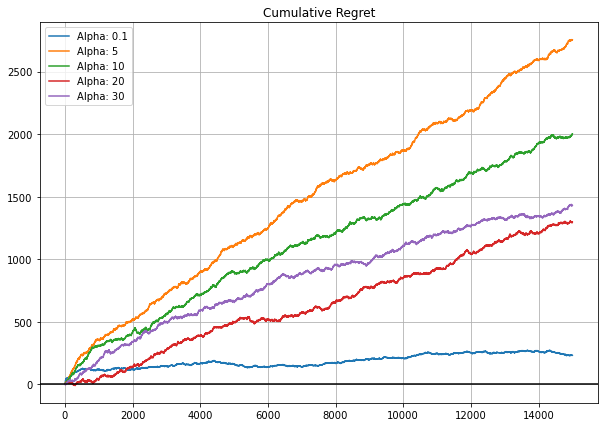

In [891]:
n_rounds = 15000
n_iterations = 10
concs = [0.1, 5, 10, 20, 30]
labels = [f'Alpha: {i}' for i in concs]
x = []
y = []

for conc in concs:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc, temp = 0.3)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:01<00:00,  3.07s/it]


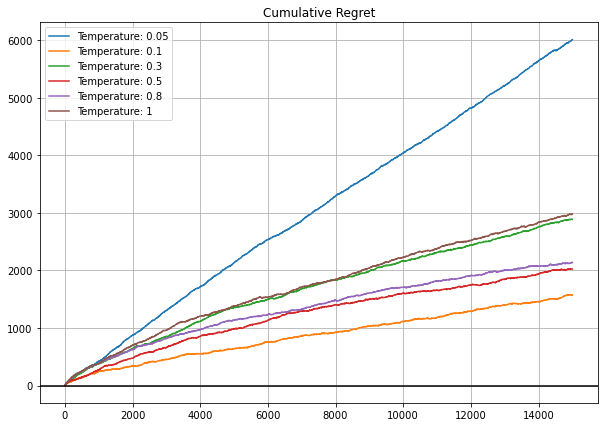

In [892]:
n_rounds = 15000
n_iterations = 20
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]
x = []
y = []

for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.5, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.98s/it]


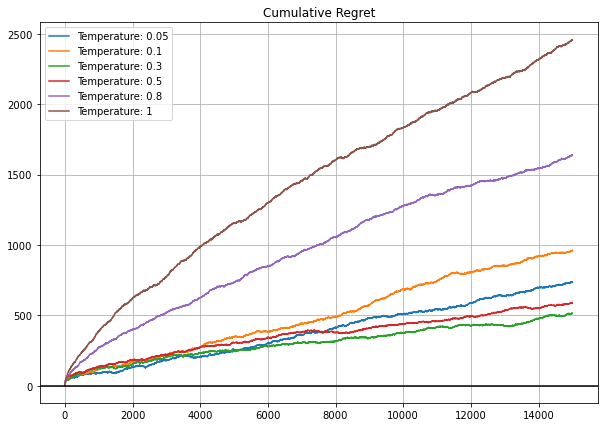

In [893]:
n_rounds = 15000
n_iterations = 20
env = env_generation(n_arms = 10, n_variables = 10, conc = 0.1)
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]
x = []
y = []

for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 0.1, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:59<00:00,  2.97s/it]


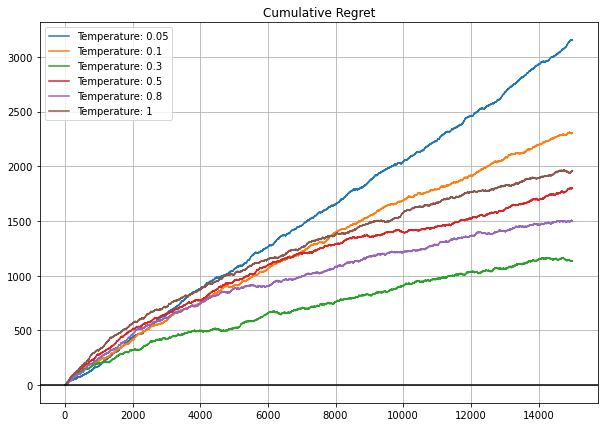

In [894]:
n_rounds = 15000
n_iterations = 20
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]
x = []
y = []

for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = 10, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Bernoulli

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [01:17<00:00,  3.89s/it]


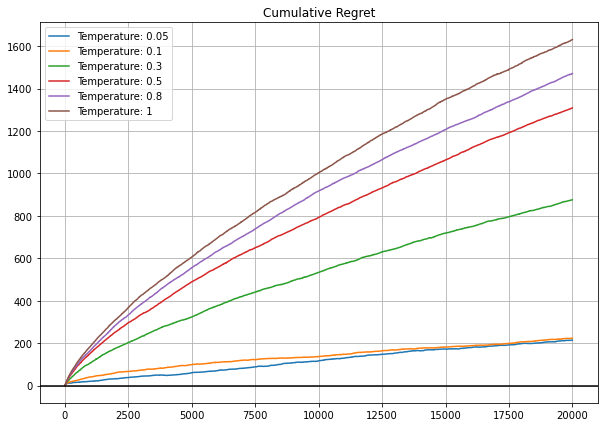

In [895]:
n_iterations = 20
n_rounds = 20000
dist = 'Bernoulli'
temps = [0.05, 0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Poisson

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:32<00:00,  1.64s/it]


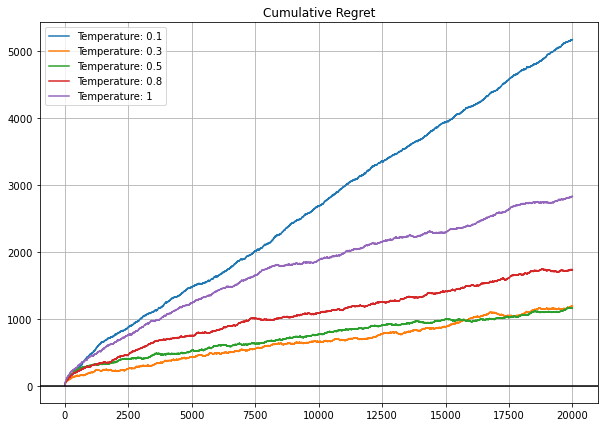

In [796]:
dist = 'Poisson'
lambdas = np.arange(1,11,1)
n_iterations = 20
n_rounds = 20000
temps = [0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.43s/it]


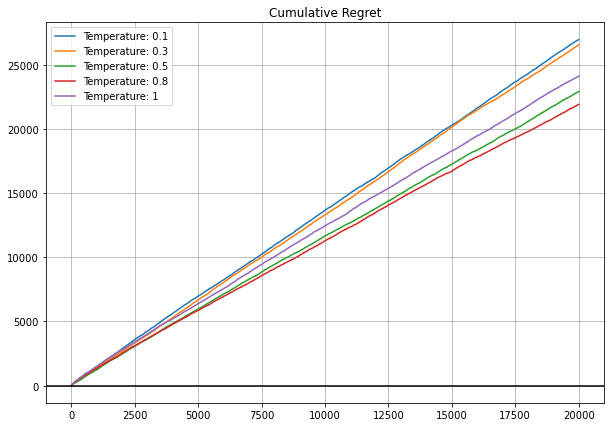

In [797]:
dist = 'Poisson'
lambdas = np.arange(10,21,1)
n_iterations = 20
n_rounds = 20000
temps = [0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

## Exponential

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:37<00:00,  1.87s/it]


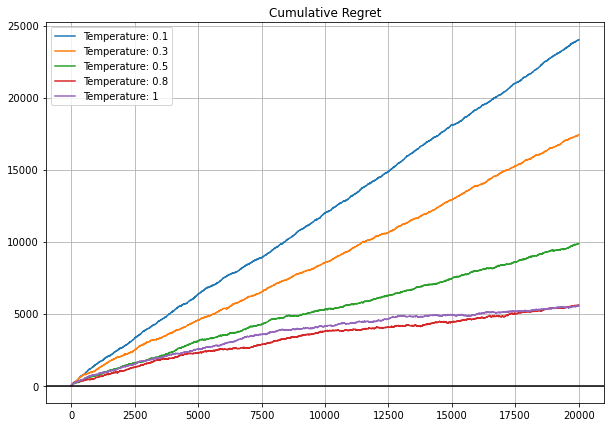

In [798]:
dist = 'Exponential'
lambdas = np.arange(1,11,1)
n_iterations = 20
n_rounds = 20000
temps = [0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.45s/it]


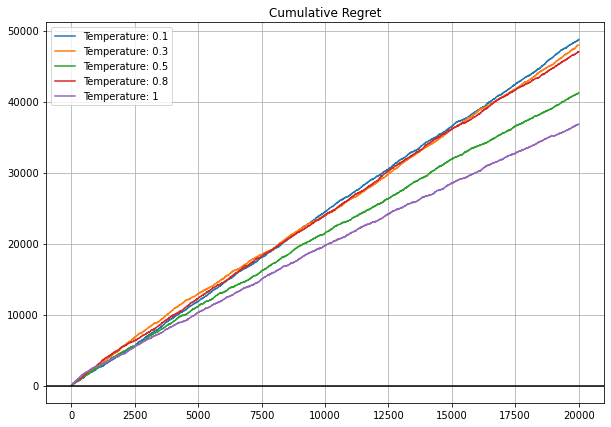

In [801]:
dist = 'Exponential'
lambdas = np.arange(10,21,1)
n_iterations = 20
n_rounds = 20000
temps = [0.1, 0.3, 0.5, 0.8, 1]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:28<00:00,  1.40s/it]


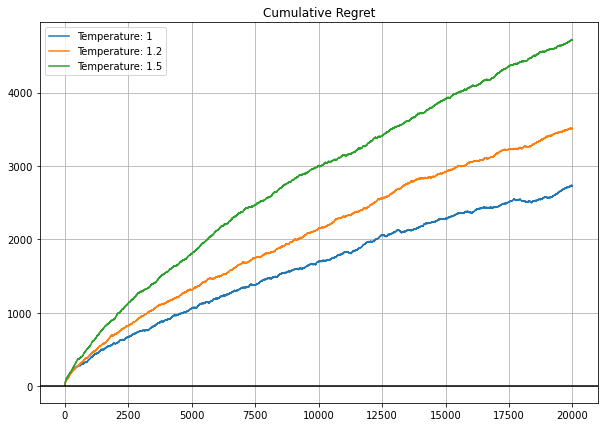

In [802]:
dist = 'Poisson'
lambdas = np.arange(1,11,1)
n_iterations = 20
n_rounds = 20000
temps = [1,1.2,1.5]
labels = [f'Temperature: {i}' for i in temps]

x = []
y = []
for temp in temps:
    all_regrets = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist, temp = temp)[0]
    y.append(all_regrets.mean(axis = 0))
    x.append(np.arange(1, n_rounds + 1))
    
cum_regret_plot(x, y, labels, big = True)

# Comparison

## Dirichlet Case

In [24]:
def dirichlet_comparison(n_rounds, n_iterations, n_arms, n_variables, conc, beta_1, beta_v, soft_temp, soft_eps_temp, title, dist = 'Dirichlet'):
    regrets_thom, choices_thom = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lb = 1, ub = n_variables, conc = conc)
    regrets_ucb1, choices_ucb1 = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_1, conc = conc)
    regrets_ucbv, choices_ucbv = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_v, conc = conc)
    regrets_moss, choices_moss = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc)
    regrets_eps, choices_eps = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc)
    regrets_soft, choices_soft = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc, temp = soft_temp)
    regrets_soft_eps, choices_soft_eps = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc, temp = soft_eps_temp)

    all_regrets = [regrets_ucb1.mean(axis = 0), regrets_ucbv.mean(axis = 0), regrets_moss.mean(axis = 0), regrets_eps.mean(axis = 0), regrets_soft.mean(axis = 0), regrets_soft_eps.mean(axis = 0), regrets_thom.mean(axis = 0)]
    all_choices = [choices_ucb1, choices_ucbv, choices_moss, choices_eps, choices_soft, choices_soft_eps, choices_thom]
    all_stds = [regrets_ucb1.std(axis = 0), regrets_ucbv.std(axis = 0), regrets_moss.std(axis = 0), regrets_eps.std(axis = 0), regrets_soft.std(axis = 0), regrets_soft_eps.std(axis = 0), regrets_thom.std(axis = 0)]
    cols = ['ucb1', 'ucbv', 'moss', 'epsilon', 'softmax', 'soft-eps', 'thompson']
    
    exp_data = pd.DataFrame()
    for i in range(len(all_regrets)):
        exp_data[cols[i] + '_regrets'] = all_regrets[i]
        exp_data[cols[i] + '_choices'] = all_choices[i]
        exp_data[cols[i] + '_stds'] = all_stds[i]
    
    file_name = title + '.csv'
    exp_data.to_csv(file_name)

In [25]:
def dirichlet_choices(n_rounds, n_iterations, n_arms, n_variables, conc, beta_1, beta_v, beta_moss, soft_temp, soft_eps_temp, title, d, dist = 'Dirichlet'):
    regrets_thom, choices_thom = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lb = 1, ub = n_variables, conc = conc)
    regrets_ucb1, choices_ucb1 = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_1, conc = conc)
    regrets_ucbv, choices_ucbv = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_v, conc = conc)
    regrets_moss, choices_moss = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc)
    regrets_eps, choices_eps = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc)
    regrets_soft, choices_soft = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc, temp = soft_temp)
    regrets_soft_eps, choices_soft_eps = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, conc = conc, temp = soft_eps_temp)

    all_choices = [choices_ucb1, choices_ucbv, choices_moss, choices_eps, choices_soft, choices_soft_eps, choices_thom]
    cols = ['ucb1', 'ucbv', 'moss', 'epsilon', 'softmax', 'soft-eps', 'thompson']
    
    exp_data = pd.DataFrame()
    for i in range(len(all_choices)):
        for j in range(len(choices_ucb1)):
            exp_data[cols[i] + '_' + str(j)] = all_choices[i][j, :]
        
    file_name = title + '_Choices'+ '.csv'
    exp_data.to_csv(file_name)

In [912]:
#Base Case

n_rounds = 100000
n_iterations = 50
n_arms = 10
n_variables = 10
conc = 0.5
beta_1 = 2
beta_v = 1
soft_temp = 0.1
soft_eps_temp = 0.3
title = 'Dirichlet_Base'
dirichlet_comparison(n_rounds = n_rounds, n_iterations = n_iterations, n_arms = n_arms, n_variables = n_variables, conc = conc, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, title = title, dist = 'Dirichlet')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [16:28<00:00, 19.77s/it]


In [140]:
#Base Case - Choices

n_rounds = 50000
n_iterations = 100
n_arms = 10
n_variables = 10
conc = 0.5
beta_1 = 2
beta_v = 1
soft_temp = 0.1
soft_eps_temp = 0.3
title = 'Dirichlet_Base'
dirichlet_choices(n_rounds = n_rounds, n_iterations = n_iterations, n_arms = n_arms, n_variables = n_variables, conc = conc, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, title = title, dist = 'Dirichlet')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [16:47<00:00, 10.08s/it]


In [913]:
#Uniform Distributions

n_rounds = 100000
n_iterations = 50
n_arms = 10
n_variables = 10
conc = 10
beta_1 = 1
beta_v = 1
soft_temp = 0.1
soft_eps_temp = 0.3
title = 'Dirichlet_Uniform'
dirichlet_comparison(n_rounds = n_rounds, n_iterations = n_iterations, n_arms = n_arms, n_variables = n_variables, conc = conc, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, title = title, dist = 'Dirichlet')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [15:00<00:00, 18.02s/it]


In [141]:
#Uniform Distributions - Choices

n_rounds = 100000
n_iterations = 50
n_arms = 10
n_variables = 10
conc = 10
beta_1 = 1
beta_v = 1
soft_temp = 0.1
soft_eps_temp = 0.3
title = 'Dirichlet_Uniform'
dirichlet_choices(n_rounds = n_rounds, n_iterations = n_iterations, n_arms = n_arms, n_variables = n_variables, conc = conc, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, title = title, dist = 'Dirichlet')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [16:30<00:00, 19.81s/it]


In [914]:
# Almost Degenerate Distributions

n_rounds = 100000
n_iterations = 50
n_arms = 10
n_variables = 10
conc = 0.1
beta_1 = 2
beta_v = 1
soft_temp = 0.3
soft_eps_temp = 0.3
title = 'Dirichlet_Degenerate'
dirichlet_comparison(n_rounds = n_rounds, n_iterations = n_iterations, n_arms = n_arms, n_variables = n_variables, conc = conc, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, title = title, dist = 'Dirichlet')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [15:23<00:00, 18.47s/it]


In [142]:
# Almost Degenerate Distributions - Choices

n_rounds = 50000
n_iterations = 100
n_arms = 10
n_variables = 10
conc = 0.1
beta_1 = 2
beta_v = 1
soft_temp = 0.3
soft_eps_temp = 0.3
title = 'Dirichlet_Degenerate'
dirichlet_choices(n_rounds = n_rounds, n_iterations = n_iterations, n_arms = n_arms, n_variables = n_variables, conc = conc, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, title = title, dist = 'Dirichlet')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [15:59<00:00,  9.60s/it]


## Bernoulli Case

In [26]:
def bernoulli_comparison(n_rounds, n_iterations, n_arms, n_variables, beta_1, beta_v, soft_temp, soft_eps_temp, l_rate, max_iter, title, dist = 'Bernoulli'):
    regrets_eps, choices_eps = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)
    regrets_soft, choices_soft = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, temp = soft_temp, dist = dist)
    regrets_soft_eps, choices_soft_eps = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, temp = soft_eps_temp, dist = dist)
    regrets_ucb1, choices_ucb1 = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_1, dist = dist)
    regrets_ucbv, choices_ucbv = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_v, dist = dist)
    regrets_moss, choices_moss = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)
    regrets_kl, choices_kl = ucb_kl_experiment_generation(n_rounds, n_iterations, dist = dist, l_rate = l_rate, max_iter = max_iter)
    regrets_bayes, choices_bayes = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)
    regrets_thom, choices_thom = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lb = 0, ub = 1)
    
    all_regrets = [regrets_ucb1.mean(axis = 0), regrets_ucbv.mean(axis = 0), regrets_moss.mean(axis = 0), regrets_eps.mean(axis = 0), regrets_soft.mean(axis = 0), regrets_soft_eps.mean(axis = 0), regrets_thom.mean(axis = 0), regrets_bayes.mean(axis = 0), regrets_kl.mean(axis = 0)]
    all_choices = [choices_ucb1, choices_ucbv, choices_moss, choices_eps, choices_soft, choices_soft_eps, choices_thom, choices_bayes, choices_kl]
    all_stds = [regrets_ucb1.std(axis = 0), regrets_ucbv.std(axis = 0), regrets_moss.std(axis = 0), regrets_eps.std(axis = 0), regrets_soft.std(axis = 0), regrets_soft_eps.std(axis = 0), regrets_thom.std(axis = 0), regrets_bayes.std(axis = 0), regrets_kl.std(axis = 0)]
    cols = ['ucb1', 'ucbv', 'moss', 'epsilon', 'softmax', 'soft-eps', 'thompson', 'ucbbayes', 'ucbkl']
    
    exp_data = pd.DataFrame()
    for i in range(len(all_regrets)):
        exp_data[cols[i] + '_regrets'] = all_regrets[i]
        exp_data[cols[i] + '_choices'] = all_choices[i]
        exp_data[cols[i] + '_stds'] = all_stds[i]
    
    file_name = title + '.csv'
    exp_data.to_csv(file_name)

In [37]:
def bernoulli_choices(n_rounds, n_iterations, n_arms, n_variables, beta_1, beta_v, soft_temp, soft_eps_temp, l_rate, max_iter, title, dist = 'Bernoulli'):
    regrets_kl, choices_kl = ucb_kl_experiment_generation(n_rounds, n_iterations, dist = dist, l_rate = l_rate, max_iter = max_iter)
    regrets_bayes, choices_bayes = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)
    regrets_thom, choices_thom = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lb = 0, ub = 1)
    regrets_eps, choices_eps = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)
    regrets_soft, choices_soft = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, temp = soft_temp, dist = dist)
    regrets_soft_eps, choices_soft_eps = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, temp = soft_eps_temp, dist = dist)
    regrets_ucb1, choices_ucb1 = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_1, dist = dist)
    regrets_ucbv, choices_ucbv = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_v, dist = dist)
    regrets_moss, choices_moss = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist)
    
    all_choices = [choices_ucb1, choices_ucbv, choices_moss, choices_eps, choices_soft, choices_soft_eps, choices_thom, choices_bayes, choices_kl]
    cols = ['ucb1', 'ucbv', 'moss', 'epsilon', 'softmax', 'soft-eps', 'thompson', 'ucbbayes', 'ucbkl']
    
    exp_data = pd.DataFrame()
    for i in range(len(all_choices)):
        for j in range(len(choices_ucb1)):
            exp_data[cols[i] + '_' + str(j)] = all_choices[i][j, :]
        
    file_name = title + '_Choices'+ '.csv'
    exp_data.to_csv(file_name)

In [925]:
n_rounds = 100000
n_iterations = 50
n_arms = 10
n_variables = 2
beta_1 = 1
beta_v = 1
soft_temp = 0.05
soft_eps_temp = 0.05
l_rate = 0.2
max_iter = 10000
title = 'Bernoulli_Base'
bernoulli_comparison(n_rounds = n_rounds, n_iterations = n_iterations, n_arms = n_arms, n_variables = n_variables, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, l_rate = l_rate, max_iter = max_iter, title = title, dist = 'Bernoulli')

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [21:12<00:00, 25.44s/it]


In [38]:
n_rounds = 50000
n_iterations = 100
n_arms = 10
n_variables = 2
beta_1 = 1
beta_v = 1
soft_temp = 0.05
soft_eps_temp = 0.05
l_rate = 0.2
max_iter = 10000
title = 'Bernoulli'
bernoulli_choices(n_rounds = n_rounds, n_iterations = n_iterations, n_arms = n_arms, n_variables = n_variables, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, l_rate = l_rate, max_iter = max_iter, title = title, dist = 'Bernoulli')

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [12:32<00:00,  7.53s/it]


In [483]:
n_rounds = 5000
n_iterations = 2
dist = 'Bernoulli'
env = env_generation(n_arms = n_arms, n_variables = 2, dist = dist)
regrets_thom = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, env = env)
regrets_bayes = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, env = env)
regrets_kl = ucb_kl_experiment_generation(n_rounds, n_iterations, env = env, dist = env.dist, l_rate = 0.01, max_iter = 10000)
regrets_ucb1 = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = 1, env = env)
regrets_ucbv = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = 1, env = env)
regrets_moss = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, env = env)
regrets_eps = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, env = env)
regrets_soft = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, env = env, temp = 0.3)
regrets_soft_eps = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, env = env, temp = 0.05)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.78s/it]


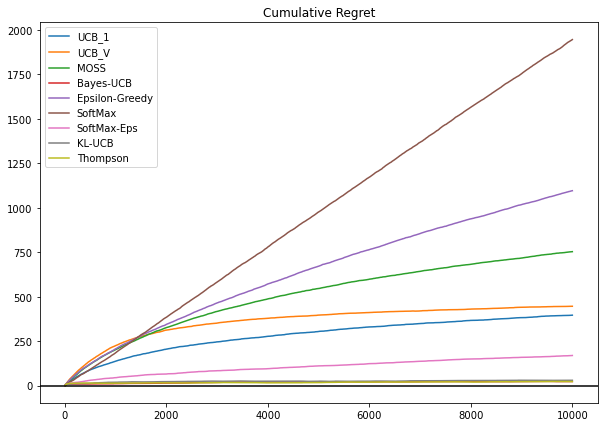

In [484]:
y = [regrets_ucb1.mean(axis = 0), 
     regrets_ucbv.mean(axis = 0), 
     regrets_moss.mean(axis = 0),
     regrets_bayes.mean(axis = 0),
     regrets_eps.mean(axis = 0), 
     regrets_soft.mean(axis = 0), 
     regrets_soft_eps.mean(axis = 0),
     regrets_kl.mean(axis = 0),
     regrets_thom.mean(axis = 0)]
x = [np.arange(1, n_rounds + 1) for i in range(len(y))]
labels = ['UCB_1', 'UCB_V', 'MOSS', 'Bayes-UCB', 'Epsilon-Greedy', 'SoftMax', 'SoftMax-Eps', 'KL-UCB', 'Thompson']
cum_regret_plot(x, y, labels, big = True)

## Poisson Case

In [42]:
def pois_exp_comparison(n_rounds, n_iterations, beta_1, beta_v, soft_temp, soft_eps_temp, l_rate, max_iter, lambdas, title, dist):
    if dist == 'Poisson':
        lb =  np.random.poisson(lam = np.min(lambdas), size = 2000).min()
        ub = np.random.poisson(lam = np.max(lambdas), size = 2000).max()
    elif dist == 'Exponential':
        ub = np.random.exponential(scale = np.max(lambdas), size = 2000).max()
        lb = np.random.exponential(scale = np.min(lambdas), size = 2000).min()
    
    regrets_ucbv, choices_ucbv = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_v, lambdas = lambdas, dist = dist)
    regrets_kl, choices_kl = ucb_kl_experiment_generation(n_rounds, n_iterations, dist = dist, l_rate = l_rate, max_iter = max_iter, lambdas = lambdas)
    regrets_bayes, choices_bayes = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)
    regrets_thom, choices_thom = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas, lb = 0, ub = ub)
    regrets_ucb1, choices_ucb1 = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_1, lambdas = lambdas, dist = dist)
    regrets_moss, choices_moss = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist)
    regrets_eps, choices_eps = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist)
    regrets_soft, choices_soft = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, temp = soft_temp, lambdas = lambdas, dist = dist)
    regrets_soft_eps, choices_soft_eps = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, temp = soft_eps_temp, lambdas = lambdas, dist = dist)
    
    all_regrets = [regrets_ucb1.mean(axis = 0), regrets_ucbv.mean(axis = 0), regrets_moss.mean(axis = 0), regrets_eps.mean(axis = 0), regrets_soft.mean(axis = 0), regrets_soft_eps.mean(axis = 0), regrets_thom.mean(axis = 0), regrets_bayes.mean(axis = 0), regrets_kl.mean(axis = 0)]
    all_choices = [choices_ucb1.mean(axis = 0), choices_ucbv.mean(axis = 0), choices_moss.mean(axis = 0), choices_eps.mean(axis = 0), choices_soft.mean(axis = 0), choices_soft_eps.mean(axis = 0), choices_thom.mean(axis = 0), choices_bayes.mean(axis = 0), choices_kl.mean(axis = 0)]
    all_stds = [regrets_ucb1.std(axis = 0), regrets_ucbv.std(axis = 0), regrets_moss.std(axis = 0), regrets_eps.std(axis = 0), regrets_soft.std(axis = 0), regrets_soft_eps.std(axis = 0), regrets_thom.std(axis = 0), regrets_bayes.std(axis = 0), regrets_kl.std(axis = 0)]
    cols = ['ucb1', 'ucbv', 'moss', 'epsilon', 'softmax', 'soft-eps', 'thompson', 'ucbbayes', 'ucbkl']
    
    exp_data = pd.DataFrame()
    for i in range(len(all_regrets)):
        exp_data[cols[i] + '_regrets'] = all_regrets[i]
        exp_data[cols[i] + '_choices'] = all_choices[i]
        exp_data[cols[i] + '_stds'] = all_stds[i]
    
    file_name = title + '.csv'
    exp_data.to_csv(file_name)

In [4]:
def pois_exp_choices(n_rounds, n_iterations, beta_1, beta_v, soft_temp, soft_eps_temp, l_rate, max_iter, lambdas, title, dist):
    if dist == 'Poisson':
        lb =  np.random.poisson(lam = np.min(lambdas), size = 2000).min()
        ub = np.random.poisson(lam = np.max(lambdas), size = 2000).max()
    elif dist == 'Exponential':
        ub = np.random.exponential(scale = np.max(lambdas), size = 2000).max()
        lb = np.random.exponential(scale = np.min(lambdas), size = 2000).min()
    
    regrets_ucbv, choices_ucbv = ucb_v_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_v, lambdas = lambdas, dist = dist)
    regrets_moss, choices_moss = ucb_moss_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist)
    regrets_eps, choices_eps = eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, lambdas = lambdas, dist = dist)
    regrets_soft, choices_soft = softmax_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, temp = soft_temp, lambdas = lambdas, dist = dist)
    regrets_soft_eps, choices_soft_eps = softmax_eps_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, temp = soft_eps_temp, lambdas = lambdas, dist = dist)
    regrets_kl, choices_kl = ucb_kl_experiment_generation(n_rounds, n_iterations, dist = dist, l_rate = l_rate, max_iter = max_iter, lambdas = lambdas)
    regrets_bayes, choices_bayes = bayes_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas)
    regrets_thom, choices_thom = thompson_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, dist = dist, lambdas = lambdas, lb = 0, ub = ub)
    regrets_ucb1, choices_ucb1 = ucb_1_experiment_generation(n_rounds = n_rounds, n_iterations = n_iterations, beta = beta_1, lambdas = lambdas, dist = dist)
    
    all_choices = [choices_ucb1, choices_ucbv, choices_moss, choices_eps, choices_soft, choices_soft_eps, choices_thom, choices_bayes, choices_kl]
    cols = ['ucb1', 'ucbv', 'moss', 'epsilon', 'softmax', 'soft-eps', 'thompson', 'ucbbayes', 'ucbkl']
    
    exp_data = pd.DataFrame()
    for i in range(len(all_choices)):
        for j in range(len(choices_ucb1)):
            exp_data[cols[i] + '_' + str(j)] = all_choices[i][j, :]
        
    file_name = title + '_Choices'+ '.csv'
    exp_data.to_csv(file_name)

In [46]:
n_rounds = 50000
n_iterations = 100
beta_1 = 2
beta_v = 1
soft_temp = 0.3
soft_eps_temp = 0.5
l_rate = 0.01
max_iter = 10000
dist = 'Poisson'
lambdas = np.arange(1,11,1)
title = 'Poisson_1'
pois_exp_choices(n_rounds = n_rounds, n_iterations = n_iterations, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, l_rate = l_rate, max_iter = max_iter, lambdas = lambdas, title = title, dist = dist)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [07:12<00:00,  4.32s/it]


In [33]:
n_rounds = 100000
n_iterations = 50
beta_1 = 3
beta_v = 1
soft_temp = 0.3
soft_eps_temp = 0.8
l_rate = 0.01
max_iter = 10000
dist = 'Poisson'
lambdas = np.arange(10,21,1)
title = 'Poisson_2'
pois_exp_choices(n_rounds = n_rounds, n_iterations = n_iterations, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, l_rate = l_rate, max_iter = max_iter, lambdas = lambdas, title = title, dist = dist)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:25<00:00,  7.72s/it]


## Exponential

In [35]:
n_rounds = 100000
n_iterations = 50
beta_1 = 6
beta_v = 1
soft_temp = 0.8
soft_eps_temp = 1
l_rate = 0.01
max_iter = 10000
dist = 'Exponential'
lambdas = np.arange(1,11,1)
title = 'Exponential_1'
pois_exp_choices(n_rounds = n_rounds, n_iterations = n_iterations, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, l_rate = l_rate, max_iter = max_iter, lambdas = lambdas, title = title, dist = dist)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:32<00:00,  6.64s/it]


In [6]:
n_rounds = 50000
n_iterations = 100
beta_1 = 6
beta_v = 1
soft_temp = 0.8
soft_eps_temp = 1
l_rate = 0.01
max_iter = 10000
dist = 'Exponential'
lambdas = np.arange(10,21,1)
title = 'Exponential_2'
pois_exp_choices(n_rounds = n_rounds, n_iterations = n_iterations, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, l_rate = l_rate, max_iter = max_iter, lambdas = lambdas, title = title, dist = dist)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:36<00:00,  2.77s/it]


In [665]:
n_rounds = 1000
n_iterations = 2
beta_1 = 1
beta_v = 1
soft_temp = 0.3
soft_eps_temp = 0.3
l_rate = 0.01
max_iter = 10000
dist = 'Exponential'
lambdas = np.arange(1,11,1)
title = 'trial'
pois_exp_comparison(n_rounds = n_rounds, n_iterations = n_iterations, beta_1 = beta_1, beta_v = beta_v, soft_temp = soft_temp, soft_eps_temp = soft_eps_temp, l_rate = l_rate, max_iter = max_iter, lambdas = lambdas, title = title, dist = dist)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  8.33it/s]


# Real Data Experiment: Ads Optimization

In [667]:
ads = pd.read_csv('Ads_Optimisation.csv')
print(ads.shape)
ads.head()

(10000, 10)


Ad 1  Ad 2  Ad 3  Ad 4  Ad 5  Ad 6  Ad 7  Ad 8  Ad 9  Ad 10
0     1     0     0     0     1     0     0     0     1      0
1     0     0     0     0     0     0     0     0     1      0
2     0     0     0     0     0     0     0     0     0      0
3     0     1     0     0     0     0     0     1     0      0
4     0     0     0     0     0     0     0     0     0      0

In [668]:
def real_experiment(data, player, beta = None, dist = None, l_rate = None, max_iter = None, lb = 0, ub = 0, temp = None):
    n_arms = data.shape[1]
    best_arm = np.argmax(data.mean(axis = 0))
    
    if player == 'ucb_1':
        player_1 = ucb_1_player(n_arms = n_arms, beta = beta)
    elif player == 'ucb_v':
         player_1 = ucb_v_player(n_arms = n_arms, beta = beta)
    elif player == 'ucb_moss':
        player_1 = ucb_moss_player(n_arms = n_arms, n_rounds = data.shape[0])
    elif player == 'ucb_kl':
        player_1 = ucb_kl_player(n_arms = n_arms, dist = dist)
    elif player == 'ucb_bayes':
        player_1 = bayes_player(n_arms = n_arms, dist = dist)
    elif player == 'thompson':
        player_1 = thom_player(n_arms = n_arms, dist = dist, lb = lb, ub = ub)
    elif player == 'epsilon':
        player_1 = eps_player(n_arms = n_arms)
    elif player == 'softmax':
        player_1 = softmax_player(n_arms = n_arms, temp = temp)
    elif player == 'soft_eps':
        player_1 = soft_eps_player(n_arms = n_arms, temp = temp)
    
    for i in tqdm(range(1, data.shape[0] + 1)):
        if i <= n_arms:
            choice = i - 1
            player_1.choices.append(choice)
        else:
            if player in ['ucb_1', 'ucb_v', 'ucb_moss', 'ucb_bayes']:
                player_1.compute_ucbs(i)
                choice = player_1.choice()
            elif player == 'ucb_kl':
                player_1.compute_ucbs(i, l_rate = l_rate, max_iter = max_iter)
                choice = player_1.choice()
            elif player in ['epsilon', 'soft_eps']:
                exp = player_1.exp_vs_exp(i)
                choice = player_1.choice(exp)
            elif player == 'softmax':
                player_1.compute_probs()
                choice = player_1.choice()
            elif player == 'thompson':
                choice = player_1.choice()
        
        reward = data.iloc[i-1, choice]
        best_reward  = data.iloc[i-1, best_arm]
        player_1.update_n_trials(choice)
        player_1.update_mean(choice, reward)
        player_1.update_regret(reward, best_reward)
        if player == 'ucb_v':
            player_1.update_variance(choice)
        elif player == 'ucb_bayes':
            player_1.update_params(choice, reward)
        elif player == 'thompson':
            if dist != 'Bernoulli':
                norm_reward = player_1.normalize(reward)
                player_1.update_params(choice, norm_reward)
            else:
                player_1.update_params(choice, reward)
    return player_1.cumulative_regrets, player_1.choices

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4029.62it/s]


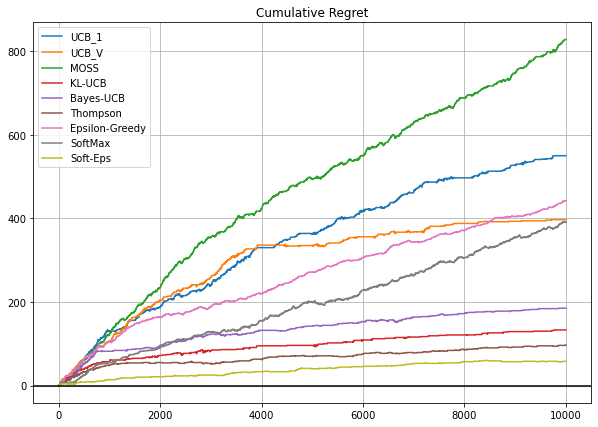

In [677]:
n_rounds = ads.shape[0]
ucb_1_regrets, ucb_1_choices = real_experiment(data = ads, player = 'ucb_1', beta = 1)
ucb_v_regrets, ucb_v_choices = real_experiment(data = ads, player = 'ucb_v', beta = 1)
ucb_moss_regrets, ucb_moss_choices = real_experiment(data = ads, player = 'ucb_moss')
ucb_kl_regrets, ucb_kl_choices = real_experiment(data = ads, player = 'ucb_kl', dist = 'Bernoulli', l_rate = 0.01, max_iter = 10000)
ucb_bayes_regrets, ucb_bayes_choices = real_experiment(data = ads, player = 'ucb_bayes', dist = 'Bernoulli')
thom_regrets, thom_choices = real_experiment(data = ads, player = 'thompson', dist = 'Bernoulli', lb = 0, ub = 1)
eps_regrets, eps_choices = real_experiment(data = ads, player = 'epsilon')
soft_regrets, soft_choices = real_experiment(data = ads, player = 'softmax', temp = 0.05)
soft_eps_regrets, soft_eps_choices = real_experiment(data = ads, player = 'soft_eps', temp = 0.05)

y = [ucb_1_regrets, 
     ucb_v_regrets, 
     ucb_moss_regrets,
     ucb_kl_regrets,
     ucb_bayes_regrets, 
     thom_regrets, 
     eps_regrets,
     soft_regrets,
     soft_eps_regrets]
x = [np.arange(1, n_rounds + 1) for i in range(len(y))]
labels = ['UCB_1', 'UCB_V', 'MOSS', 'KL-UCB', 'Bayes-UCB', 'Thompson', 'Epsilon-Greedy', 'SoftMax', 'Soft-Eps']
cum_regret_plot(x, y, labels, big = True)

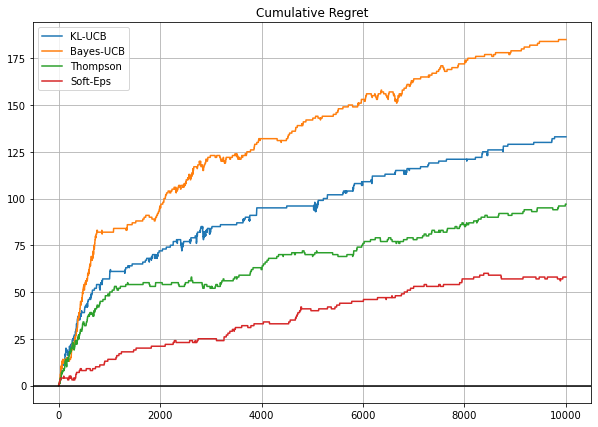

In [678]:
y = [ucb_kl_regrets,
     ucb_bayes_regrets, 
     thom_regrets, 
     soft_eps_regrets]

x = [np.arange(1, n_rounds + 1) for i in range(len(y))]
labels = ['KL-UCB', 'Bayes-UCB', 'Thompson','Soft-Eps']
cum_regret_plot(x, y, labels, big = True)

In [684]:
experiment_ads = pd.DataFrame()
all_regrets = [ucb_1_regrets, ucb_v_regrets, ucb_kl_regrets, ucb_bayes_regrets, ucb_moss_regrets, thom_regrets, eps_regrets, soft_regrets, soft_eps_regrets]
all_choices = [ucb_1_choices, ucb_v_choices, ucb_kl_choices, ucb_bayes_choices, ucb_moss_choices, thom_choices, eps_choices, soft_choices, soft_eps_choices]
titles = ['ucb1', 'ucbv', 'ucbkl', 'ucbbayes', 'ucbmoss', 'thompson', 'epsilon', 'softmax', 'softeps']
for i in range(len(all_regrets)):
    experiment_ads[titles[i] + '_regrets'] = all_regrets[i]
    experiment_ads[titles[i] + '_choices'] = all_choices[i]
#experiment_ads.to_csv('Ads_Experiment_Results.csv')
experiment_ads.head()

ucb1_regrets  ucb1_choices  ucbv_regrets  ucbv_choices  ucbkl_regrets  \
0             0             0             0             0              0   
1             0             1             0             1              0   
2             0             2             0             2              0   
3             0             3             0             3              0   
4             0             4             0             4              0   

   ucbkl_choices  ucbbayes_regrets  ucbbayes_choices  ucbmoss_regrets  \
0              0                 0                 0                0   
1              1                 0                 1                0   
2              2                 0                 2                0   
3              3                 0                 3                0   
4              4                 0                 4                0   

   ucbmoss_choices  thompson_regrets  thompson_choices  epsilon_regrets  \
0                0                 0                 0                0   
1                1                 0                 1                0   
2                2                 0                 2                0   
3                3                 0                 3                0   
4                4                 0                 4                0   

   epsilon_choices  softmax_regrets  softmax_choices  softeps_regrets  \
0                0                0                0                0   
1                1                0                1                0   
2                2                0                2                0   
3                3                0                3                0   
4                4                0                4                0   

   softeps_choices  
0                0  
1                1  
2                2  
3                3  
4                4

In [680]:
def choices_plot(choices, size, title):
    plt.plot([np.mean(choices[i:i + size]) for i in range(len(choices) - size)])
    plt.axhline(4, color = 'black', label = 'Best')
    plt.title(title)
    plt.legend()
    plt.show()

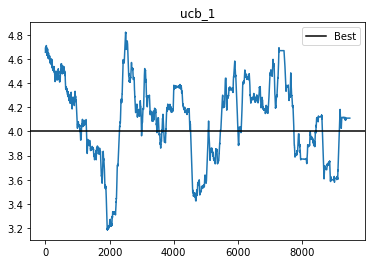

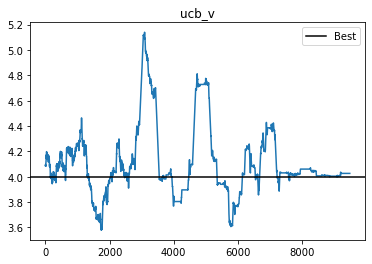

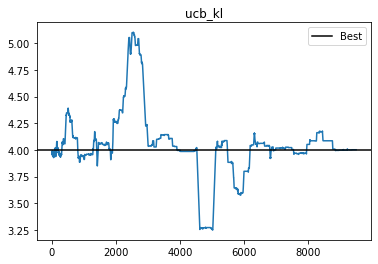

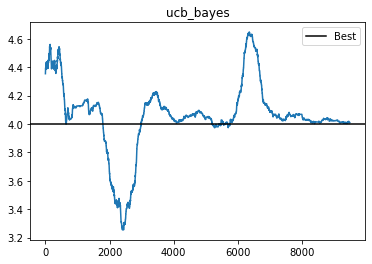

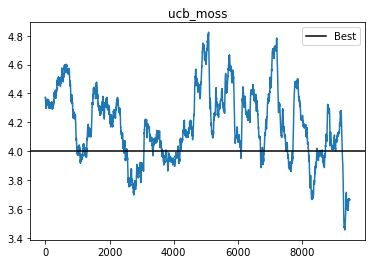

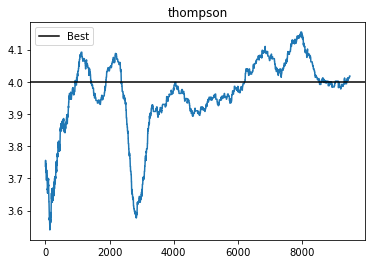

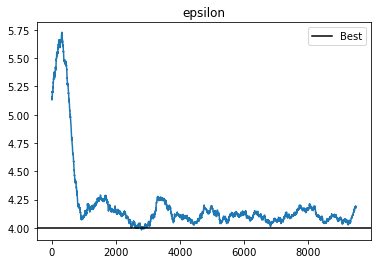

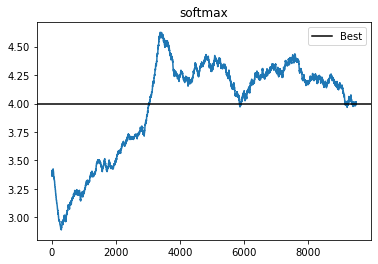

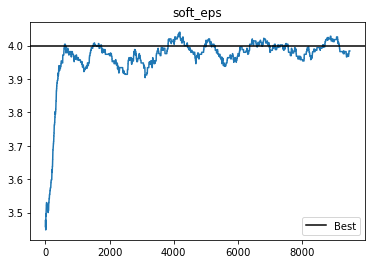

In [681]:
all_choices = [ucb_1_choices, ucb_v_choices, ucb_kl_choices, ucb_bayes_choices, ucb_moss_choices, thom_choices, eps_choices, soft_choices, soft_eps_choices]
titles = ['ucb_1', 'ucb_v', 'ucb_kl', 'ucb_bayes', 'ucb_moss', 'thompson', 'epsilon', 'softmax', 'soft_eps']
for i in range(len(all_choices)):
    choices_plot(all_choices[i], size = 500, title = titles[i])